In [1]:
# Reset workspace

%reset -f

# Animal Group and Number

In [2]:
group_number: int = 6
rat_number: int = 6

# **Importing Libraries**

In [3]:
# Importing Python modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import hilbert
from time import perf_counter, strftime, gmtime, sleep
import plotly.figure_factory as ff
from copy import deepcopy
import plotly.express as px
from loguru import logger
import os
import mat73
from scipy.io import savemat, loadmat
from high_order_spectra_analysis.time_domain_trispectrum.tdts import tdts
from pathos.multiprocessing import ProcessingPool as Pool
from bispectrum_real_data_analysis.scripts.utils import seconds_to_formatted_time
import plotly.express as px
from plotly.subplots import make_subplots
from bispectrum_real_data_analysis.scripts.utils import standardize_array
import pendulum
from scipy import stats as st
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

%matplotlib inline

# Methods

In [4]:
# Método que calcula a FFT unilateral e retorna um plot,
# o vetor de frequências em Hertz e os ganhos
def fft(x, fs):
    N = len(x)
    FFT = np.fft.fft(x)
    P2 = np.abs(FFT/N)
    intensity = P2[0:N//2]
    intensity[1:-1] = 2*intensity[1:-1]
    frequency = fs*np.arange(0,N//2)/N
    angle = np.angle(FFT)
    angle = angle[0:N//2]
    return frequency, intensity, angle

In [5]:
def get_exact_value_between_two_points(x, y, x0):
    if len(x) != len(y):
        raise IndexError("The arrays x and y must have the same size.")
    
    two_points_x = [x[x<=x0][-1], x[x>=x0][0]]
    two_points_y = [y[x<=x0][-1], y[x>=x0][0]]
    
    f = scipy.interpolate.interp1d(two_points_x, two_points_y)
    return f(x0)

In [6]:
def intensity_fft_at_frequency(data, f0, fs):
    frequency, intensity, angle = fft(data, fs)
    return get_exact_value_between_two_points(x=frequency, y=np.power(intensity, 2), x0=f0)

In [7]:
def calculate_signal_energy(
    signal: np.ndarray,
    fs: float,
    central_frequency = 53.71,
    range_neighbors = 0.5,
    step_neighbors = 0.1
) -> np.ndarray:
    
        
    # Hz
    lateral_frequencies_steps = np.arange(0, range_neighbors+step_neighbors, step_neighbors)
    
    frequencies_array = np.hstack(
        [
            -lateral_frequencies_steps[::-1]+central_frequency, 
            (lateral_frequencies_steps+central_frequency)[1:]
        ]
    ) 
    
    energies = np.vectorize(intensity_fft_at_frequency, excluded={"data", "fs"})(
        data=signal,
        f0=frequencies_array,
        fs=fs
    )
        
    return energies

In [8]:
def get_MPC(
    signal1, 
    signal2,
    signal1_name: str = "signal_1",
    signal2_name: str = "signal_2",
    sliding_window: bool = False,
    sliding_window_size: float = 3.0,
    TimeSampling: float = None,
    plot: bool = True,
    save: bool = False,
    name_to_save: str = "fig.eps",
    legend_size=15
):
    
    if not sliding_window:
        
        analytic_signal_1 = hilbert(signal1)
        phase_data_signal_1 = np.unwrap(np.angle(analytic_signal_1))

        analytic_signal_2 = hilbert(signal2)
        phase_data_signal_2 = np.unwrap(np.angle(analytic_signal_2))

        phase_angle_diff = phase_data_signal_1 - phase_data_signal_2

        euler_phase_diff = np.exp(1j*phase_angle_diff)

        mean_phase_diff = np.mean(euler_phase_diff)

        phase_sync = np.abs(mean_phase_diff)
        
        phase_angle = np.angle(mean_phase_diff)

        print(f"The synchronization between {signal1_name} and {signal2_name} is {np.round(phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(phase_angle, 2)} rad")
         
    else:
        if TimeSampling is None:
            raise ValueError("TimeSampling must be passed as float.")

        # Mean synchronization using sliding window with 90% time overlap
        N = len(signal1)
        step = int(0.1*(sliding_window_size/TimeSampling))
        number_of_windows_overlap = int((sliding_window_size/TimeSampling)//step)
        start_window = np.arange(0, N, step).astype(int)
        end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
        end_window[-1] = N - 1

        clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
        mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)

        for i in range(number_of_windows_overlap):
            signal1_data = signal1[start_window[i]:end_window[i]]
            signal2_data = signal2[start_window[i]:end_window[i]]
            analytic_signal1 = hilbert(signal1_data)
            analytic_signal2 = hilbert(signal2_data)
            phase_data_signal1 = np.unwrap(np.angle(analytic_signal1))
            phase_data_signal2 = np.unwrap(np.angle(analytic_signal2))
            phase_angle_diff = phase_data_signal1 - phase_data_signal2
            euler_phase_diff = np.exp(1j*phase_angle_diff)
            mean_phase_diff = np.mean(euler_phase_diff)
            phase_sync = np.abs(mean_phase_diff)
            clustering_phase_array[i] = phase_sync
            mean_phase_array[i] = np.angle(mean_phase_diff)

        phase_sync = clustering_phase_array
        phase_angle = mean_phase_array
        
        mean_phase_sync = clustering_phase_array.mean()
        mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
                
        print(f"The mean synchronization between {signal1_name} and {signal2_name} is {np.round(mean_phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(mean_phase_angle, 2)} rad")
        
    if plot:
        
        ax = PolarPlotPhasors.plot_array_angles(
            phase_angle_diff if not sliding_window else phase_angle, 
            color=None, 
            linewidth=0.5,
            modules_phasors=phase_sync if sliding_window else None
        )
        
        ax = PolarPlotPhasors.add_vector_polar(
            ax, 
            angle=phase_angle if not sliding_window else mean_phase_angle, 
            module=phase_sync if not sliding_window else mean_phase_sync, 
            linewidth=5, 
            color='red'
        )

        ax.set_xlabel(
            f"\n{np.round(phase_sync if not sliding_window else mean_phase_sync, 4)}", 
            fontsize=legend_size,
            bbox_inches='tight', 
            dpi=150
        )
        
        if save:
            if name_to_save == "fig.eps" and os.path.isfile("fig.eps"):
                i = 2
                while os.path.isfile(name_to_save):
                    name_to_save =  f"fig_{i}.eps"
                    i += 1
            plt.savefig(name_to_save, format=name_to_save.split(".")[-1])
        
        plt.show()
        
    return phase_sync, phase_angle

In [9]:
class PolarPlotPhasors:
    @classmethod
    def create_polar_plot(cls, figsize=(14,10), grid=True):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='polar')
        ax.set_yticklabels([])
        plt.grid(grid)
        plt.xticks(
            [
                0, 
                0.25*np.pi, 
                0.5*np.pi,
                0.75*np.pi, 
                np.pi, 
                1.25*np.pi, 
                1.5*np.pi, 
                1.75*np.pi
            ], 
            [
                "0", 
                "$\\frac{\pi}{4}$",
                "$\\frac{\pi}{2}$",
                "$\\frac{3 \pi}{4}$",
                "$\pi$",
                "$\\frac{5\pi}{4}$",
                "$\\frac{3\pi}{2}$",
                "$\\frac{7\pi}{4}$"
            ],
            fontsize=20
        )
        ax.set_theta_zero_location('E')
        ax.set_ylim([0, 1])
        return ax
    
    @classmethod
    def add_angle_polar(cls, ax, angle, gain=1, color="gray", linewidth=1):
        ax.plot([0, angle], [0, gain], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_array_angles_colored(cls, angles, gains, color="gray", linewidth=1, grid=False):
        ax = cls.create_polar_plot(grid=grid)
        for angle, gain in zip(angles, gains):
            ax = cls.add_angle_polar(ax, angle, gain, color, linewidth)
        return ax
    
    @classmethod
    def add_vector_polar(cls, ax, angle, module, color, linewidth):
        ax.plot([0, angle], [0, module], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_two_array_angles(cls, angles1, angles2, color1="gray", color2="blue", linewidth=1, grid=False):
        ax = cls.create_polar_plot(grid=grid)

        new_angles = np.zeros((4,len(angles)))
        modules = np.zeros((4,len(angles)))

        new_angles[1, :] = new_angles[2, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1:3, :] = 1
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)

        return ax
    
    @classmethod
    def plot_array_angles(cls, angles, modules_phasors=None, color="gray", linewidth=1, grid=False):

        gains = 1 if modules_phasors is None else modules_phasors
        
        ax = cls.create_polar_plot(grid=grid)

        new_angles = np.zeros((2,len(angles)))
        modules = np.zeros((2,len(angles)))

        new_angles[1, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1, :] = gains
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)
        
        del new_angles
        del modules
        del gains

        return ax

In [10]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """

    window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

In [12]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filtfilt=False):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if filtfilt:
        return signal.filtfilt(b, a, data)
    return signal.lfilter(b, a, data)

In [13]:
def decimate(data: pd.DataFrame, desired_frequency_sampling: float, filter: bool = False, time=None):
    if time is None:
        time = data.Time.to_numpy()
    TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The time sampling is {TimeSampling} seconds and the frequency is "
        f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = np.ceil(newTimeSampling/TimeSampling).astype(int)
    logger.info(f"The data will be decimated by the rate 1:{decimation_rate}")

    if filter:
        matrix = data.iloc[:, 1:-2].to_numpy()
        decimated_matrix = signal.decimate(matrix, decimation_rate, axis=0, ftype='fir', zero_phase=True)
        new_data = data.copy()[::decimation_rate]
        new_data.iloc[:, 1:-2] = decimated_matrix
    else:
        new_data = data[::decimation_rate]

    TimeSampling = TimeSampling*decimation_rate
    
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    return new_data, TimeSampling, FrequencySampling

In [14]:
def sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
):


    # Mean synchronization using sliding window with 90% time overlap
    step = int(0.1*(sliding_window_size/TimeSampling))
    ic_number = 1
    number_of_windows_overlap = int((window_size/TimeSampling)//step)
    start_window = np.arange(0, len(ic_data_complete), step).astype(int)
    end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
    end_window[-1] = len(ic_data_complete) - 1

    clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
    mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)


    for i in range(number_of_windows_overlap):
        event_time_window = event_time[start_window[i]:end_window[i]]
        ic_data = ic_data_complete[start_window[i]:end_window[i]]
        phase_data_CS_event = phase_data_CS[start_window[i]:end_window[i]]
        analytic_signal_ic = hilbert(ic_data)
        phase_data_ic = np.unwrap(np.angle(analytic_signal_ic))
        phase_angle_diff = phase_data_CS_event - phase_data_ic
        euler_phase_diff = np.exp(1j*phase_angle_diff)
        mean_phase_diff = np.mean(euler_phase_diff)
        phase_sync = np.abs(mean_phase_diff)
        clustering_phase_array[i] = phase_sync
        mean_phase_array[i] = np.angle(mean_phase_diff)

    mean_phase_sync = clustering_phase_array.mean()
    mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
    ax = PolarPlotPhasors.plot_array_angles(mean_phase_array, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=mean_phase_angle, module=mean_phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(mean_phase_sync, 4)}", fontsize=16)
    plt.show()

In [15]:
def get_spectogram(x: np.ndarray, fs: float, nfft=None, nperseg=None, noverlap=None):
    f, t, Sxx = signal.spectrogram(x, fs, nfft=nfft, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx    

In [16]:
def plot_spectogram(
    t, 
    f, 
    Sxx, 
    ylim: list = None, 
    yticks: list = None, 
    cmap: str = 'hot', 
    title='Spectogram',
    save: bool = False,
    name_to_save: str = "fig.eps"
):
    
    plt.figure(figsize=(12,10))
    plt.title(title)
    plt.pcolormesh(t, f, Sxx, cmap=cmap)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if ylim is not None:
        plt.ylim(ylim)
    if yticks is not None:
        plt.yticks(yticks)
    if save:
        if name_to_save == "fig.eps" and os.path.isfile("fig.eps"):
            i = 2
            while os.path.isfile(name_to_save):
                name_to_save =  f"fig_{i}.eps"
                i += 1
        plt.savefig(name_to_save, format=name_to_save.split(".")[-1])
    plt.show()

In [17]:
def run_and_plot(
    event_data: pd.DataFrame, 
    fs: float, 
    ylim: list = None, 
    yticks: list = None, 
    cmap: str = 'hot', 
    title='Spectogram',
    save: bool = False,
    name_to_save: str = "fig.eps"
) -> None:

    """
    Method to plot the waveform and spectogram of the CS modullating signal paired with each channel at time.
    """
    for index_of_channel in range(1, event_data.shape[1]-1):
        
        name_of_channel = list(event_data.columns)[index_of_channel]

        logger.info(f"Channel {index_of_channel - 1}: {name_of_channel.replace('_', ' ')}")
        
        f, t, Sxx = get_spectogram(
            event_data[name_of_channel], 
            fs=fs, 
            nperseg=int(10*fs),
            noverlap=int(9*fs)
        )
        
        name_to_save = ".".join([f"{name_to_save.split('.')[0]}_{name_of_channel}", "eps"])
        
        plot_spectogram(
            t, 
            f, 
            Sxx, 
            ylim=ylim, 
            yticks=yticks, 
            cmap=cmap, 
            title=title, 
            save=save, 
            name_to_save=name_to_save
        )
        
        print("\n\n")

In [18]:
def get_MPC(
    signal1, 
    signal2,
    signal1_name: str = "signal_1",
    signal2_name: str = "signal_2",
    sliding_window: bool = False,
    sliding_window_size: float = 3.0,
    TimeSampling: float = None,
    plot: bool = True,
    save: bool = False,
    name_to_save: str = "fig.eps",
    legend_size=15,
    dpi=100
):
    
    if not sliding_window:
        
        analytic_signal_1 = hilbert(signal1)
        phase_data_signal_1 = np.unwrap(np.angle(analytic_signal_1))

        analytic_signal_2 = hilbert(signal2)
        phase_data_signal_2 = np.unwrap(np.angle(analytic_signal_2))

        phase_angle_diff = phase_data_signal_1 - phase_data_signal_2

        euler_phase_diff = np.exp(1j*phase_angle_diff)

        mean_phase_diff = np.mean(euler_phase_diff)

        phase_sync = np.abs(mean_phase_diff)
        
        phase_angle = np.angle(mean_phase_diff)

        print(f"The synchronization between {signal1_name} and {signal2_name} is {np.round(phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(phase_angle, 2)} rad")
         
    else:
        if TimeSampling is None:
            raise ValueError("TimeSampling must be passed as float.")

        # Mean synchronization using sliding window with 90% time overlap
        N = len(signal1)
        step = int(0.1*(sliding_window_size/TimeSampling))
        number_of_windows_overlap = int((sliding_window_size/TimeSampling)//step)
        start_window = np.arange(0, N, step).astype(int)
        end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
        end_window[-1] = N - 1

        clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
        mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)

        for i in range(number_of_windows_overlap):
            signal1_data = signal1[start_window[i]:end_window[i]]
            signal2_data = signal2[start_window[i]:end_window[i]]
            analytic_signal1 = hilbert(signal1_data)
            analytic_signal2 = hilbert(signal2_data)
            phase_data_signal1 = np.unwrap(np.angle(analytic_signal1))
            phase_data_signal2 = np.unwrap(np.angle(analytic_signal2))
            phase_angle_diff = phase_data_signal1 - phase_data_signal2
            euler_phase_diff = np.exp(1j*phase_angle_diff)
            mean_phase_diff = np.mean(euler_phase_diff)
            phase_sync = np.abs(mean_phase_diff)
            clustering_phase_array[i] = phase_sync
            mean_phase_array[i] = np.angle(mean_phase_diff)

        phase_sync = clustering_phase_array
        phase_angle = mean_phase_array
        
        mean_phase_sync = clustering_phase_array.mean()
        mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
                
        print(f"The mean synchronization between {signal1_name} and {signal2_name} is {np.round(mean_phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(mean_phase_angle, 2)} rad")
        
    if plot:
        
        ax = PolarPlotPhasors.plot_array_angles(
            phase_angle_diff if not sliding_window else phase_angle, 
            color=None, 
            linewidth=0.5,
            modules_phasors=phase_sync if sliding_window else None
        )
        
        ax = PolarPlotPhasors.add_vector_polar(
            ax, 
            angle=phase_angle if not sliding_window else mean_phase_angle, 
            module=phase_sync if not sliding_window else mean_phase_sync, 
            linewidth=5, 
            color='red'
        )

#         ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync if not sliding_window else mean_phase_sync, 4)}", fontsize=16)
        ax.set_xlabel(
            f"{np.round(phase_sync if not sliding_window else mean_phase_sync, 4)}", 
            fontsize=legend_size,
        )
        
        if save:
            if name_to_save == "fig.eps" and os.path.isfile("fig.eps"):
                i = 2
                while os.path.isfile(name_to_save):
                    name_to_save =  f"fig_{i}.eps"
                    i += 1
            plt.savefig(
                name_to_save, 
                format=name_to_save.split(".")[-1],
                bbox_inches='tight', 
                dpi=dpi
            )
        
        plt.show()
        
    ax.clear()
        
    del analytic_signal_1
    del phase_data_signal_1
    del analytic_signal_2
    del phase_data_signal_2
    del phase_angle_diff
    del euler_phase_diff
    del mean_phase_diff
    del ax
        
    return phase_sync, phase_angle

In [19]:
class TDTS:
    def __init__(
        self,
        frequency_sampling: float,
        time: np.ndarray | None = None,
        frequency_array: np.ndarray | None = None,
        fmin: float | None = None,
        fmax: float | None = None,
        freq_step: float = 1e-3,
        phase_step: float = 1e-3,
        dtype: np.dtype = np.float64,
        enable_progress_bar: bool = True
    ):
        self.frequency_sampling = frequency_sampling
        self.time = time
        self.frequency_array = frequency_array
        self.fmin = fmin
        self.fmax = fmax
        self.freq_step = freq_step
        self.phase_step = phase_step
        self.dtype = dtype
        self.enable_progress_bar = enable_progress_bar

    def run_tbds(self, signal_dict: np.ndarray | pd.Series): 
        event, signal = list(signal_dict.items())[0]
        return {
            event: tdts(
                signal, 
                self.frequency_sampling, 
                time=self.time, 
                frequency_array=self.frequency_array, 
                fmin=self.fmin, 
                fmax=self.fmax, 
                freq_step=self.freq_step, 
                phase_step=self.phase_step, 
                dtype=self.dtype, 
                enable_progress_bar=self.enable_progress_bar
            )
        }

In [20]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N), 'same') / N

In [21]:
def get_events(data, threshold, window_size, time_sampling):
    
    x = data.CS_modulating.to_numpy()
    N = len(x)
    index = np.arange(N)
    plt.figure(figsize=(16,14))
    plt.subplot(321)
    plt.plot(index, x)
    plt.ylabel("x")

    x = x - np.mean(x[:10])
    plt.subplot(322)
    plt.plot(index, x)
    plt.ylabel("x - mean(x)")

    x = x**2
    plt.subplot(323)
    plt.plot(index, x)
    plt.ylabel("(x - mean(x))^2")

    x = moving_average(x, window_size)
    plt.subplot(324)
    plt.plot(index, x)
    plt.axhline(threshold, color="red", label="threshold")
    plt.legend()
    plt.ylabel("moving_average_10_(x - mean(x))^2")

    x[x>threshold] = 1
    x[x<threshold] = 0

    plt.subplot(325)
    plt.plot(index, x)
    plt.ylabel("threshold(moving_average_10_(x - mean(x))^2)")

    indices = index[np.append(False, x[1:] - x[:-1]) != 0]

    for event, s, e in zip(range(1, 6), indices[0::2], indices[1::2]):
        print(f"\nEvent: {event}")
        print(f"start: {s}\nend: {e}") 
        print(f"time duration: {(e-s)*time_sampling}")

    print(f"\nlen(indices) = {len(indices)}")

    data = data.assign(event=np.empty(len(data), dtype=str))
    data.loc[:, "event"] = "base"

    for i, event in zip(range(0, len(indices), 2), np.arange(1, 6)):
        start = indices[i]
        end = indices[i+1]
        data.loc[start:end, "event"] = f"event_{event}"

    data.event.unique()

    plt.subplot(326)
    for event in data.event.unique():
        plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)

    plt.ylabel("events")

    plt.show()
    return data

# Loading files

In [22]:
# Loading and creating the data matrix

BASE_PATH = "/home/matheus/Documents/repositories/bispectrum_real_data_analysis/bispectrum_real_data_analysis/data/rats"    

logger.info(f"Loading .mat files for group {group_number} rat {rat_number}...")

data_train_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_PreTreino.mat"
data_test_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_Salina.mat"

raw_data_train = mat73.loadmat(data_train_filename)
raw_data_test = mat73.loadmat(data_test_filename)

logger.success("Creating data matrix...")

TimeSamplingTrain = 1.0/raw_data_train["srate"]
TimeSamplingTest = 1.0/raw_data_test["srate"]

N = raw_data_train["data"].shape[1]
M = raw_data_test["data"].shape[1]

timeTrain = np.arange(0, TimeSamplingTrain*N, TimeSamplingTrain)[:N]
timeTest = np.arange(0, TimeSamplingTest*M, TimeSamplingTest)[:M]

data_train = pd.DataFrame(
    {
        "Time": timeTrain,
        "CS_modulating": raw_data_train["data"][0],
        "Inferior_colliculus": raw_data_train["data"][1]
    }
) 

data_test = pd.DataFrame(
    {
        "Time": timeTest,
        "CS_modulating": raw_data_test["data"][0],
        "Inferior_colliculus": raw_data_test["data"][1]
    }
) 

logger.success("Done!")

2023-04-16 17:49:42.949 | INFO     | __main__:<module>:5 - Loading .mat files for group 6 rat 6...
2023-04-16 17:49:43.265 | SUCCESS  | __main__:<module>:13 - Creating data matrix...
2023-04-16 17:49:43.297 | SUCCESS  | __main__:<module>:40 - Done!


## Train data


Event: 1
start: 581746
end: 673276
time duration: 29.99255039508602

Event: 2
start: 856413
end: 947943
time duration: 29.99255039508602

Event: 3
start: 1222636
end: 1314166
time duration: 29.99255039508602

Event: 4
start: 1680415
end: 1771945
time duration: 29.99255039508602

Event: 5
start: 1955082
end: 2046612
time duration: 29.99255039508602

len(indices) = 10


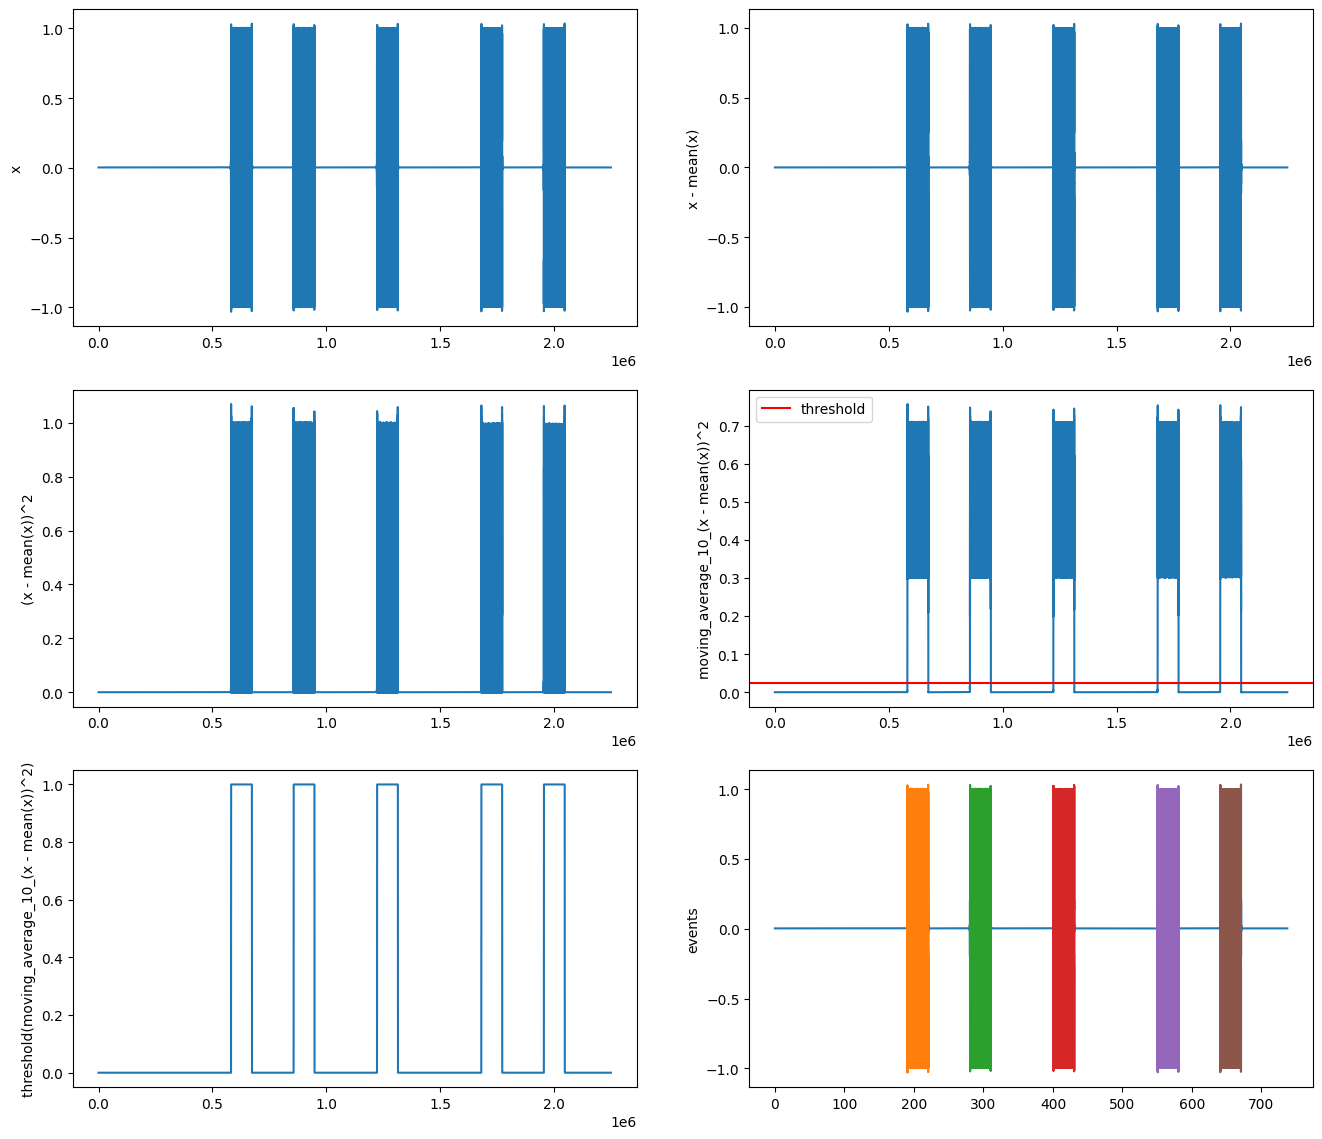

In [23]:
threshold = 0.025
window_size = 20

data_train = get_events(
    data=data_train, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTrain
)

data_train_backup = data_train

In [24]:
savemat(f"{data_train_filename.split('.')[0]}_events.mat", data_train_backup.to_dict())

In [25]:
desired_frequency_sampling = 500

data_train, TimeSampling, FrequencySampling = decimate(data_train_backup, desired_frequency_sampling=desired_frequency_sampling)

data_train.to_csv(f"{data_train_filename.split('.')[0]}_to_bispectrum.csv", index=False)

2023-04-16 17:49:49.695 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-04-16 17:49:49.695 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:7
2023-04-16 17:49:49.696 | INFO     | __main__:decimate:24 - The new time sampling is 0.0023 s and the new frequency is 435.5400696864112 Hz


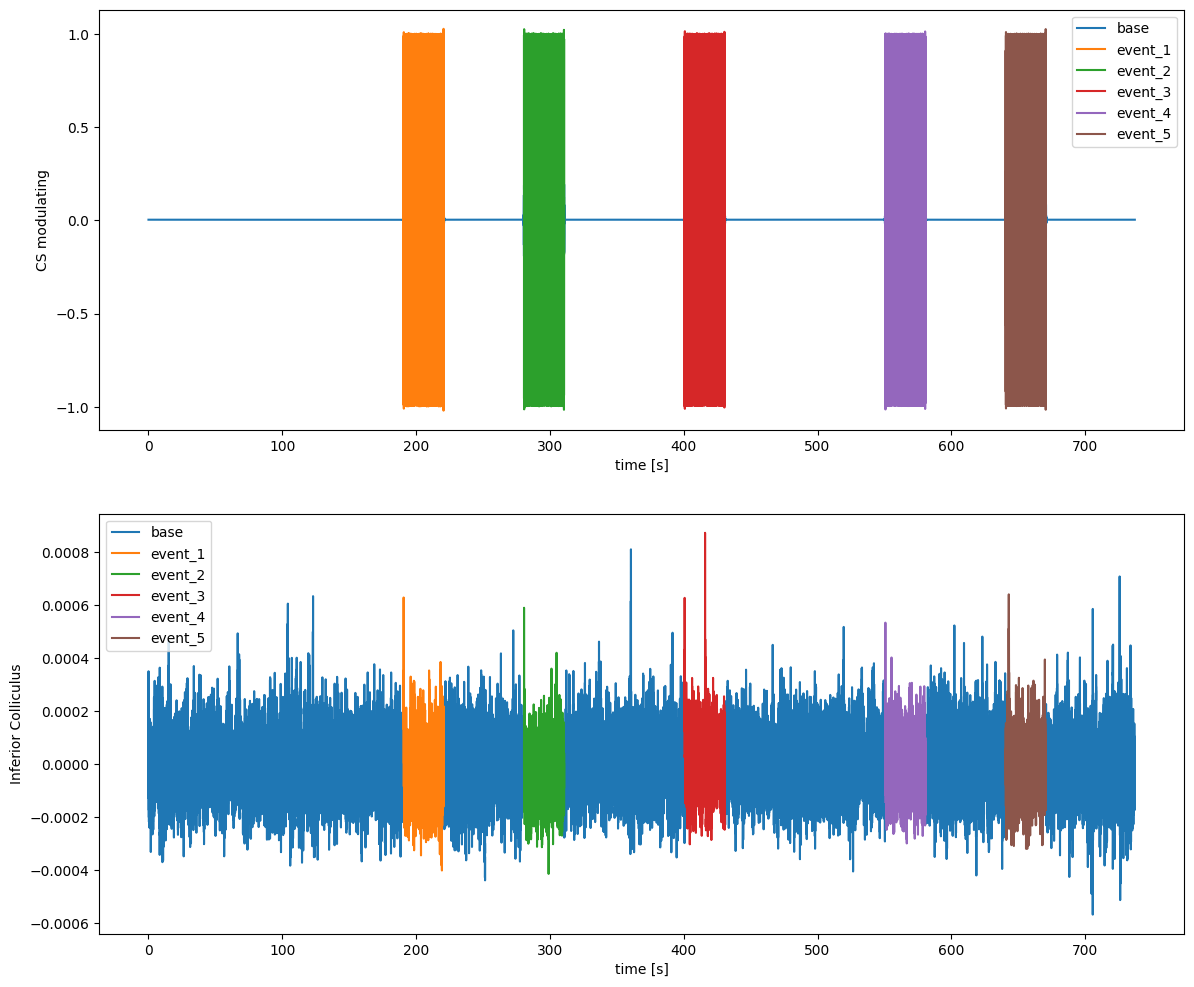

In [26]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "CS_modulating"], label=event)
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend()

plt.show()

## Test data


Event: 1
start: 581243
end: 672773
time duration: 29.99255039508602

Event: 2
start: 855908
end: 947438
time duration: 29.99255039508602

Event: 3
start: 1222128
end: 1313658
time duration: 29.99255039508602

Event: 4
start: 1679903
end: 1771433
time duration: 29.99255039508602

Event: 5
start: 1954568
end: 2046098
time duration: 29.99255039508602

len(indices) = 10


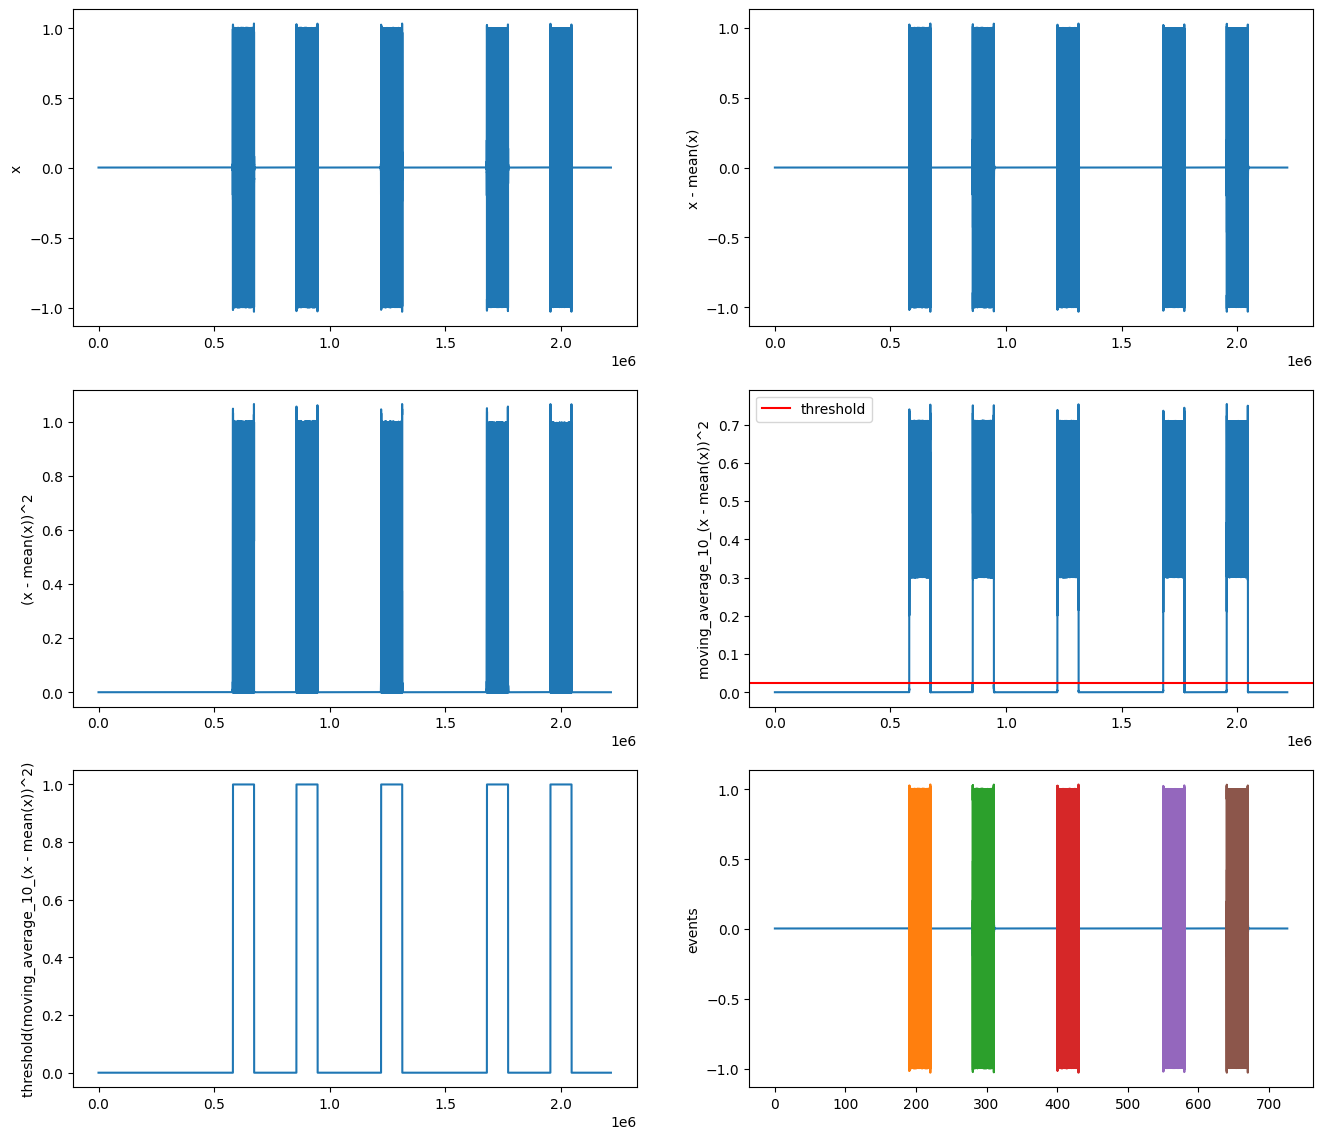

In [27]:
threshold = 0.025
window_size = 20

data_test = get_events(
    data=data_test, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTest
)

data_test_backup = data_test

In [28]:
savemat(f"{data_test_filename.split('.')[0]}_events.mat", data_test_backup.to_dict())

In [29]:
data_test, TimeSampling, FrequencySampling = decimate(data_test_backup, desired_frequency_sampling=desired_frequency_sampling)
data_test.to_csv(f"{data_test_filename.split('.')[0]}_to_bispectrum.csv", index=False)

2023-04-16 17:49:59.001 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-04-16 17:49:59.001 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:7
2023-04-16 17:49:59.002 | INFO     | __main__:decimate:24 - The new time sampling is 0.0023 s and the new frequency is 435.5400696864112 Hz


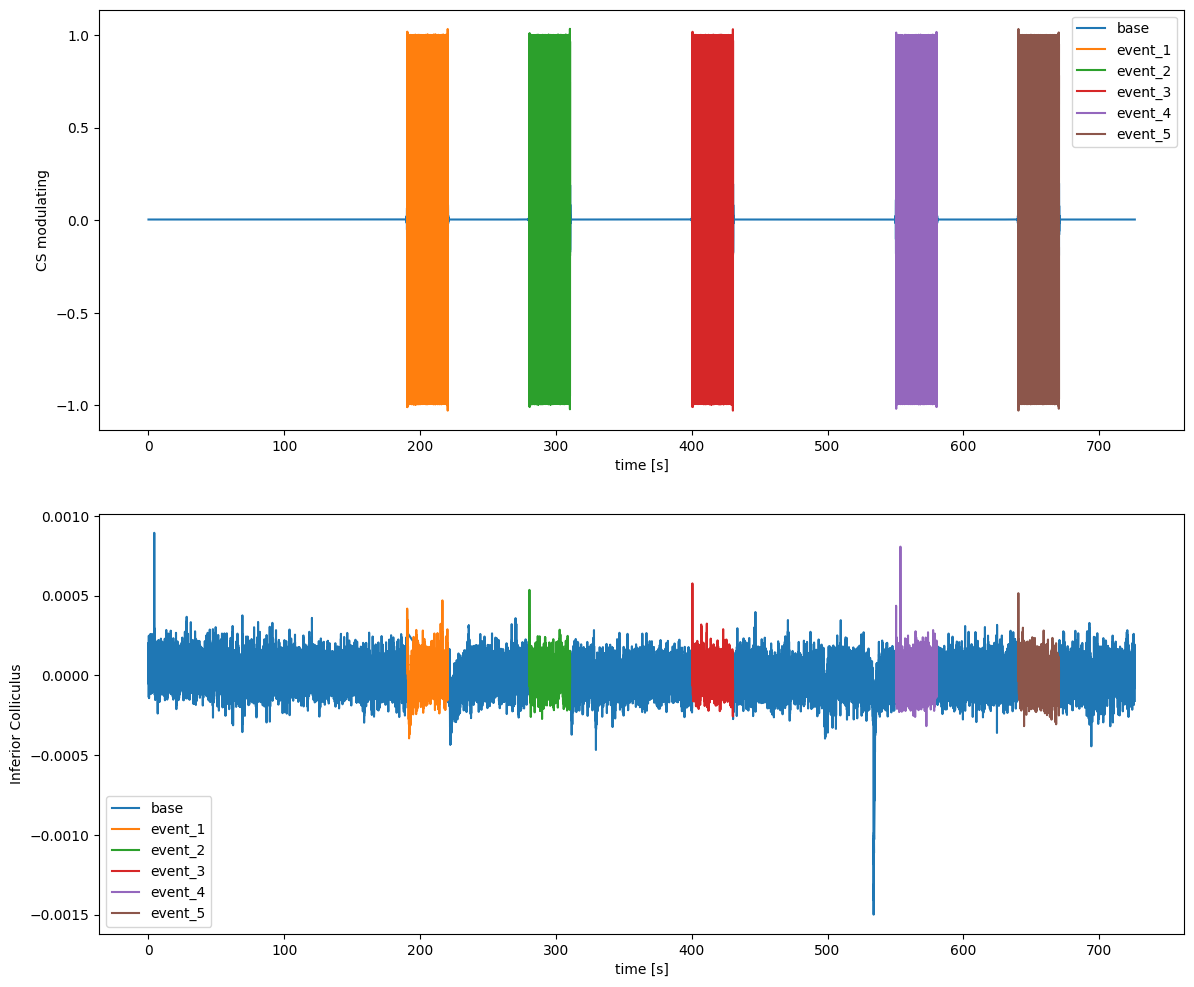

In [30]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "CS_modulating"], label=event)
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_test.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend()

plt.show()

# Data filtering

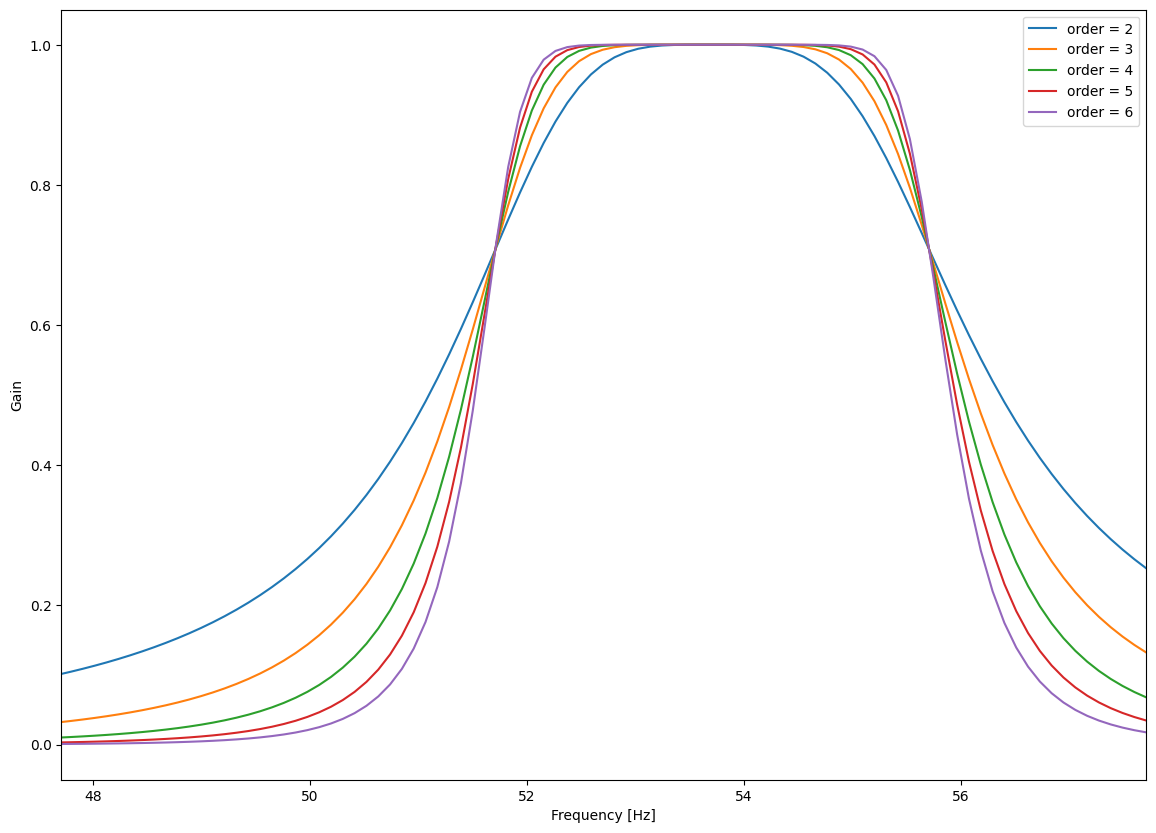

In [31]:
low_cut_hz = 53.71 - 2.0
high_cut_hz = 53.71 + 2.0
fs = 1.0/TimeSampling

plt.figure(figsize=(14,10))
plt.clf()

for order in range(2,7):
    b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs, order=order)
    w, h = signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.show()

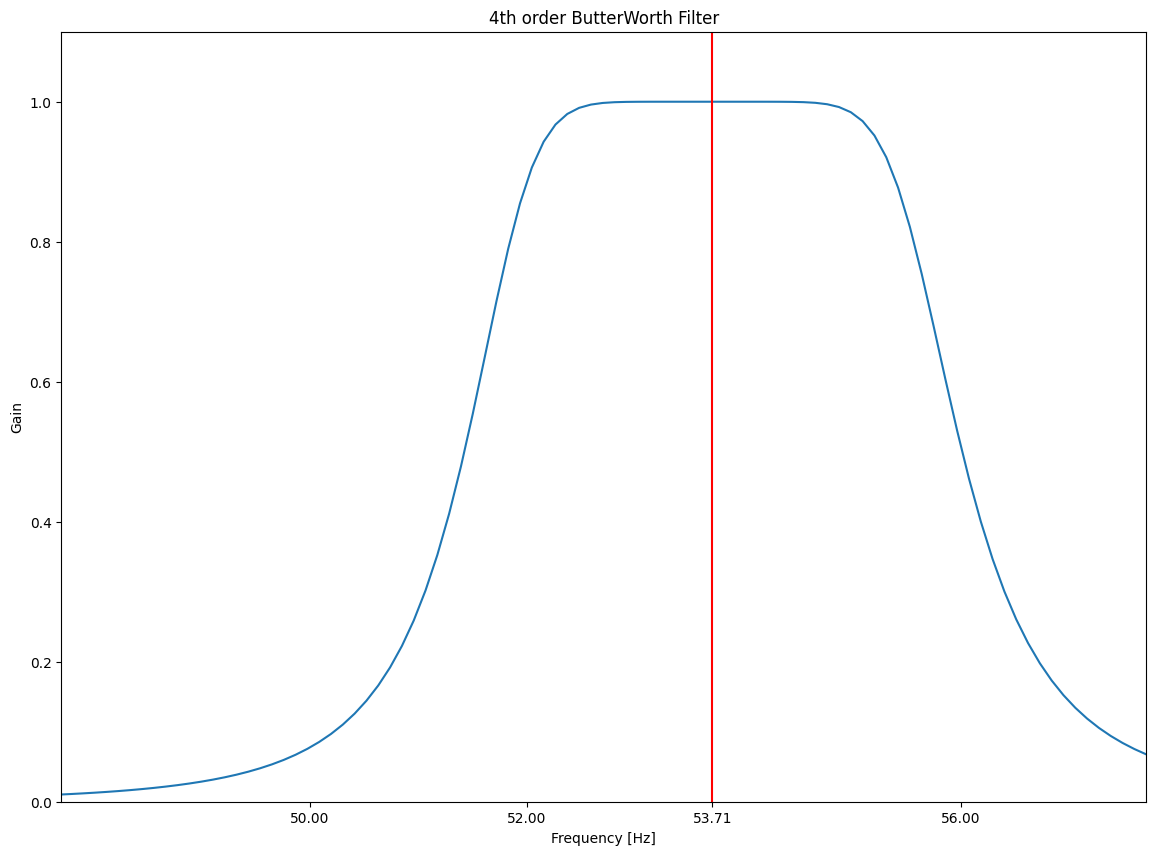

In [32]:
filter_order = 4
b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs=fs, order=filter_order)

plt.figure(figsize=(14,10))
plt.clf()
w, h = signal.freqz(b, a, fs=fs, worN=2000)
plt.plot(w, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.vlines(53.71, -1, 2, color='red')
plt.ylim([0, 1.1])
plt.xticks([50, 52, 53.71, 56])
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.title(f"{filter_order}th order ButterWorth Filter")
plt.show()

## Filtering using filtfilt to avoid phase changes

In [33]:
def filter_function(column): 
    return butter_bandpass_filter(
        data=column, 
        lowcut=low_cut_hz, 
        highcut=high_cut_hz,
        fs=fs,
        order=filter_order, 
        filtfilt=True
    )

## Filtering train data

In [34]:
data_train.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event'], dtype='object')

In [35]:
filtered_Inferior_colliculus = filter_function(data_train.Inferior_colliculus.to_numpy())
data_train = data_train.assign(filtered_Inferior_colliculus=filtered_Inferior_colliculus)

In [36]:
data_train.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event',
       'filtered_Inferior_colliculus'],
      dtype='object')

## Filtering test data

In [37]:
data_test.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event'], dtype='object')

In [38]:
filtered_Inferior_colliculus = filter_function(data_test.Inferior_colliculus.to_numpy())
data_test = data_test.assign(filtered_Inferior_colliculus=filtered_Inferior_colliculus)

In [39]:
data_test.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event',
       'filtered_Inferior_colliculus'],
      dtype='object')

# Data Visualization

## Train data

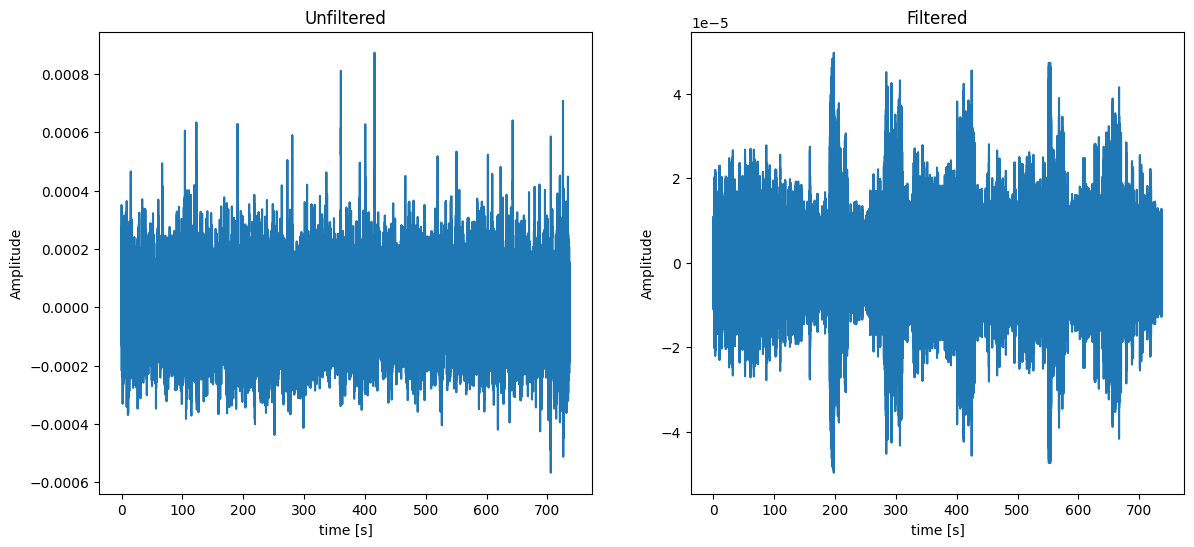

In [40]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(data_train.Time, data_train.loc[:,'Inferior_colliculus'])
plt.title("Unfiltered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(data_train.Time, data_train.loc[:,'filtered_Inferior_colliculus'])
plt.title("Filtered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.show()

## Test data

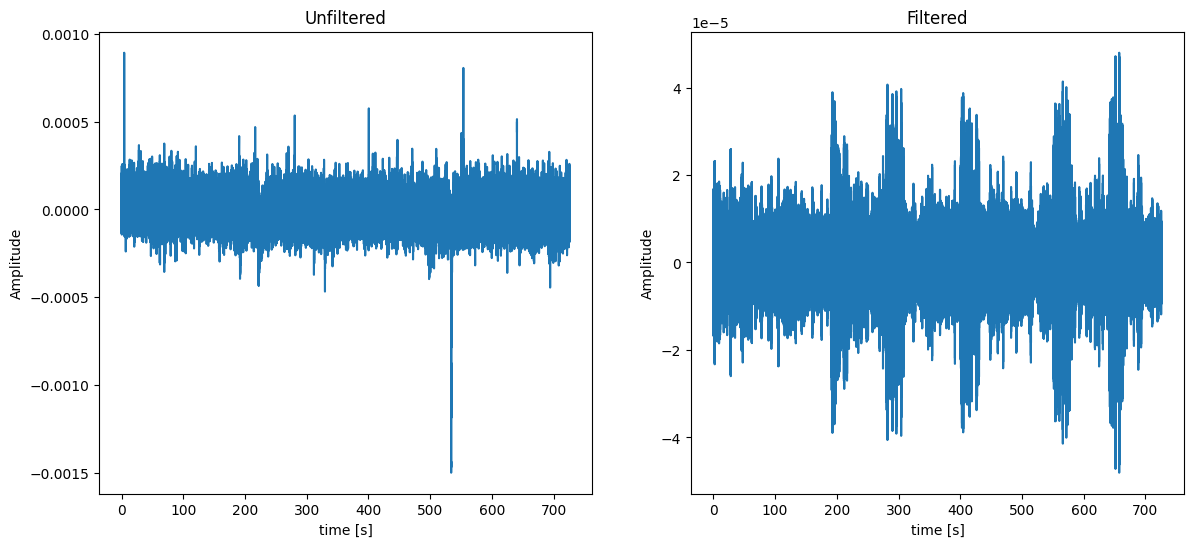

In [41]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(data_test.Time, data_test.loc[:,'Inferior_colliculus'])
plt.title("Unfiltered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(data_test.Time, data_test.loc[:,'filtered_Inferior_colliculus'])
plt.title("Filtered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.show()

# Energy

2023-04-16 17:50:02.551 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 1


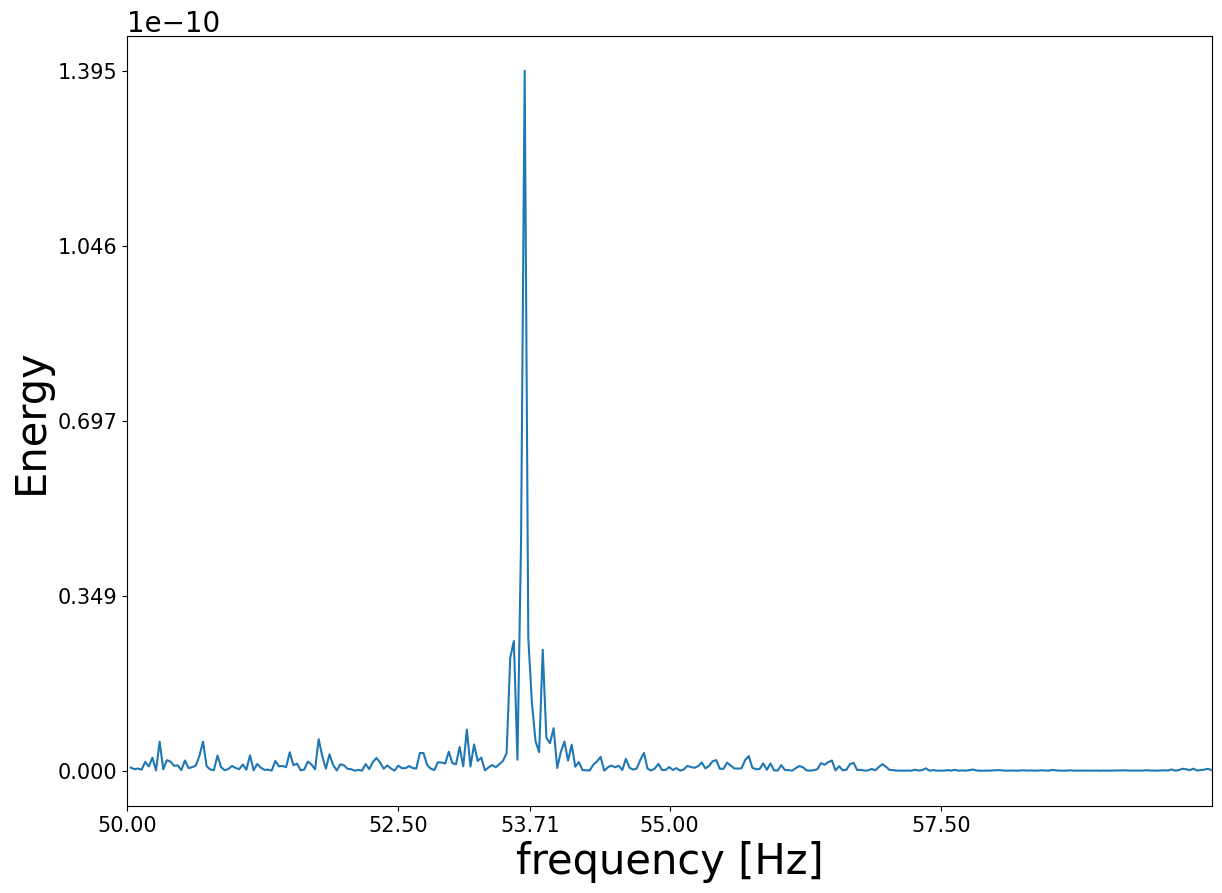

2023-04-16 17:50:02.772 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 1 - raw data
2023-04-16 17:50:02.773 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 1


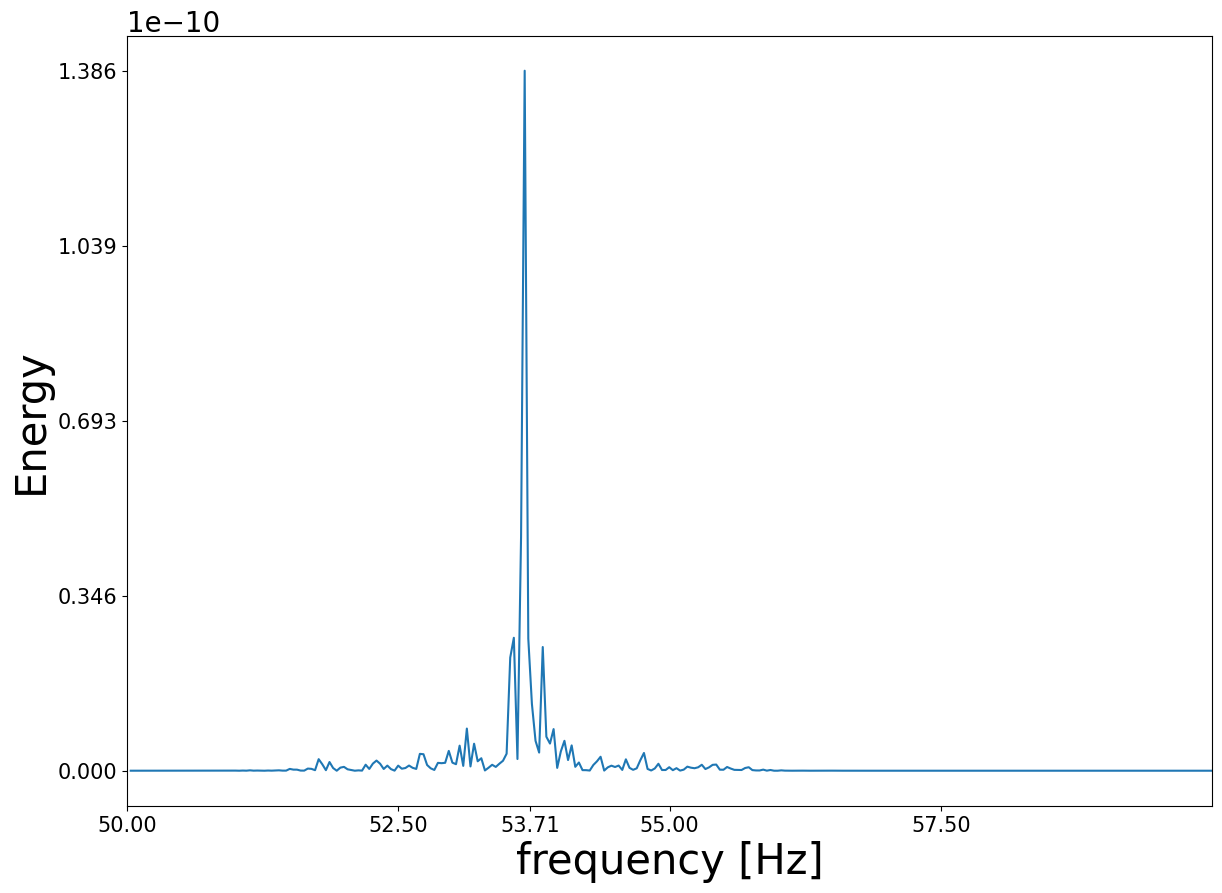

2023-04-16 17:50:02.969 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 1 - filtered data
2023-04-16 17:50:02.970 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 2


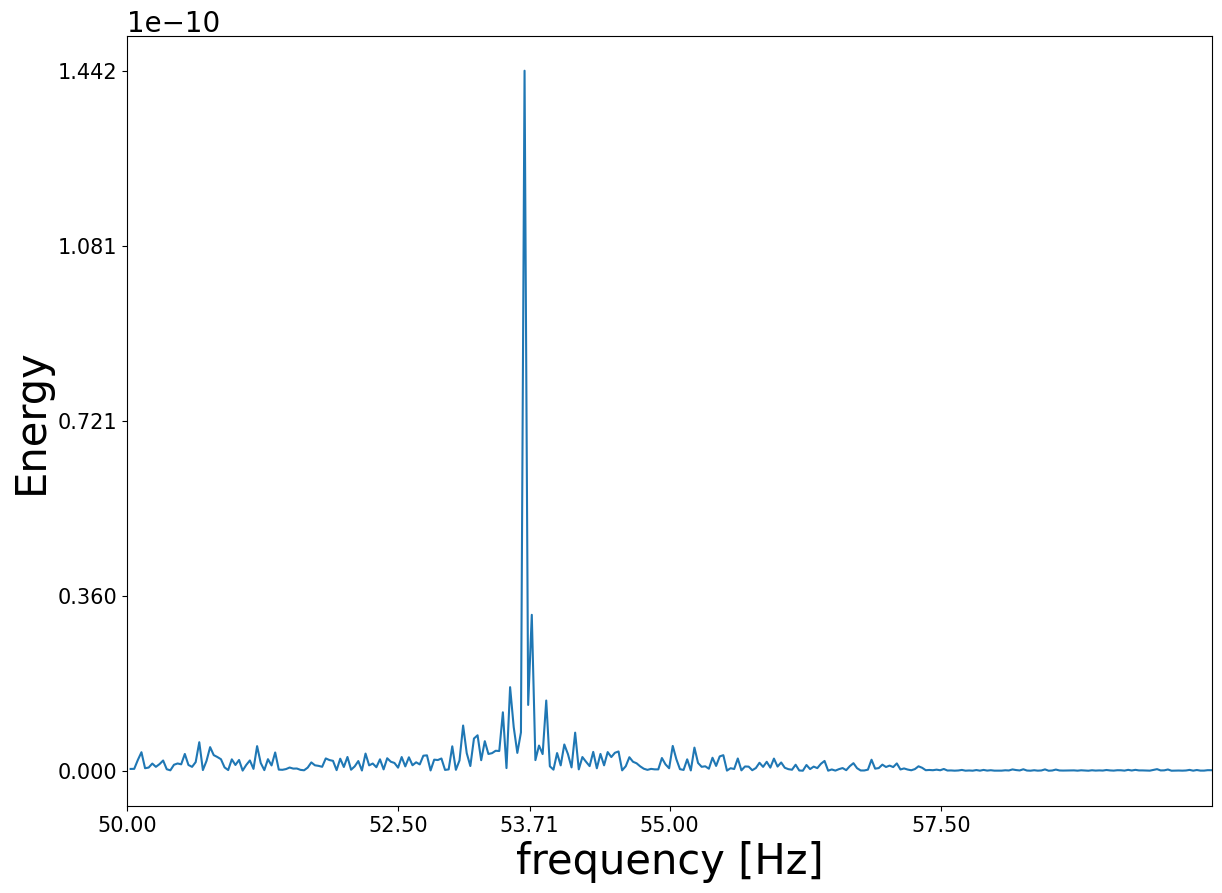

2023-04-16 17:50:03.179 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 2 - raw data
2023-04-16 17:50:03.179 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 2


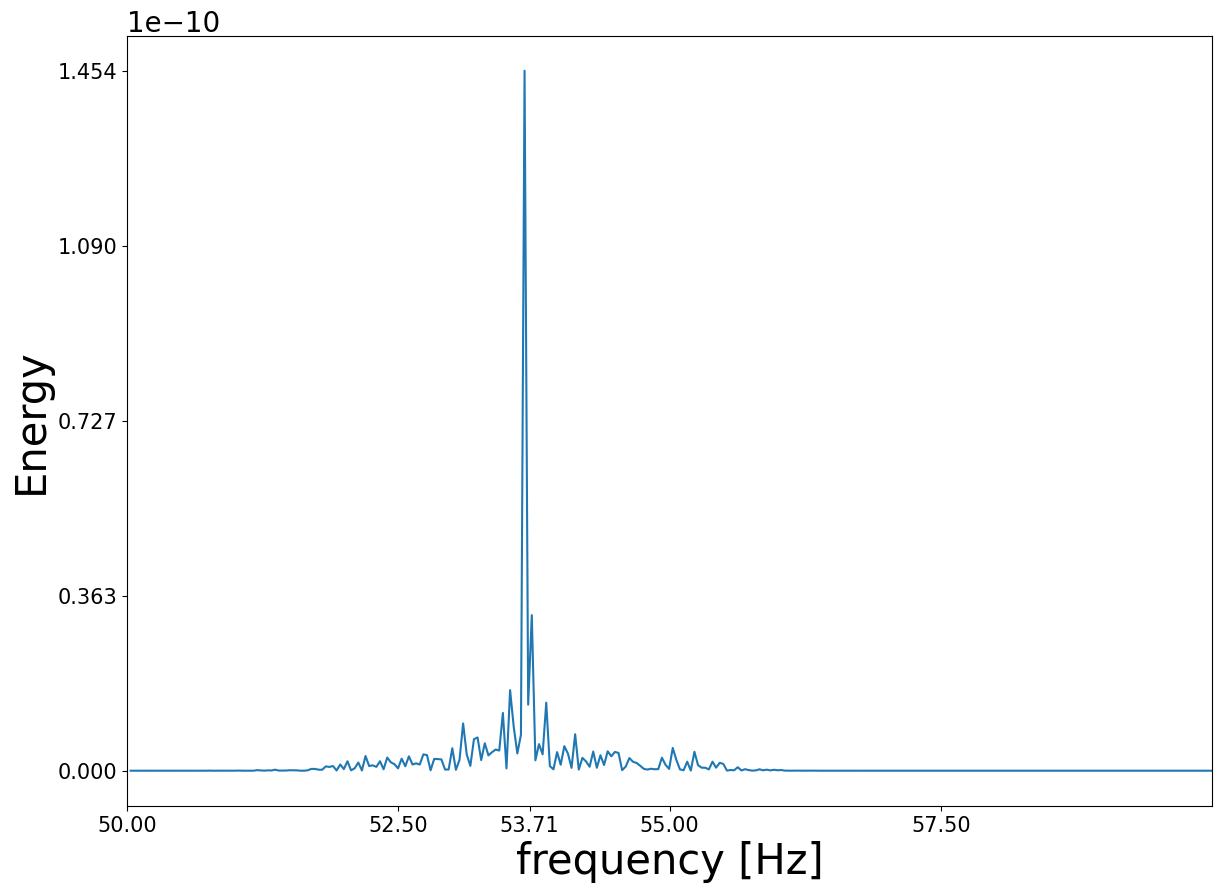

2023-04-16 17:50:03.389 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 2 - filtered data
2023-04-16 17:50:03.389 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 3


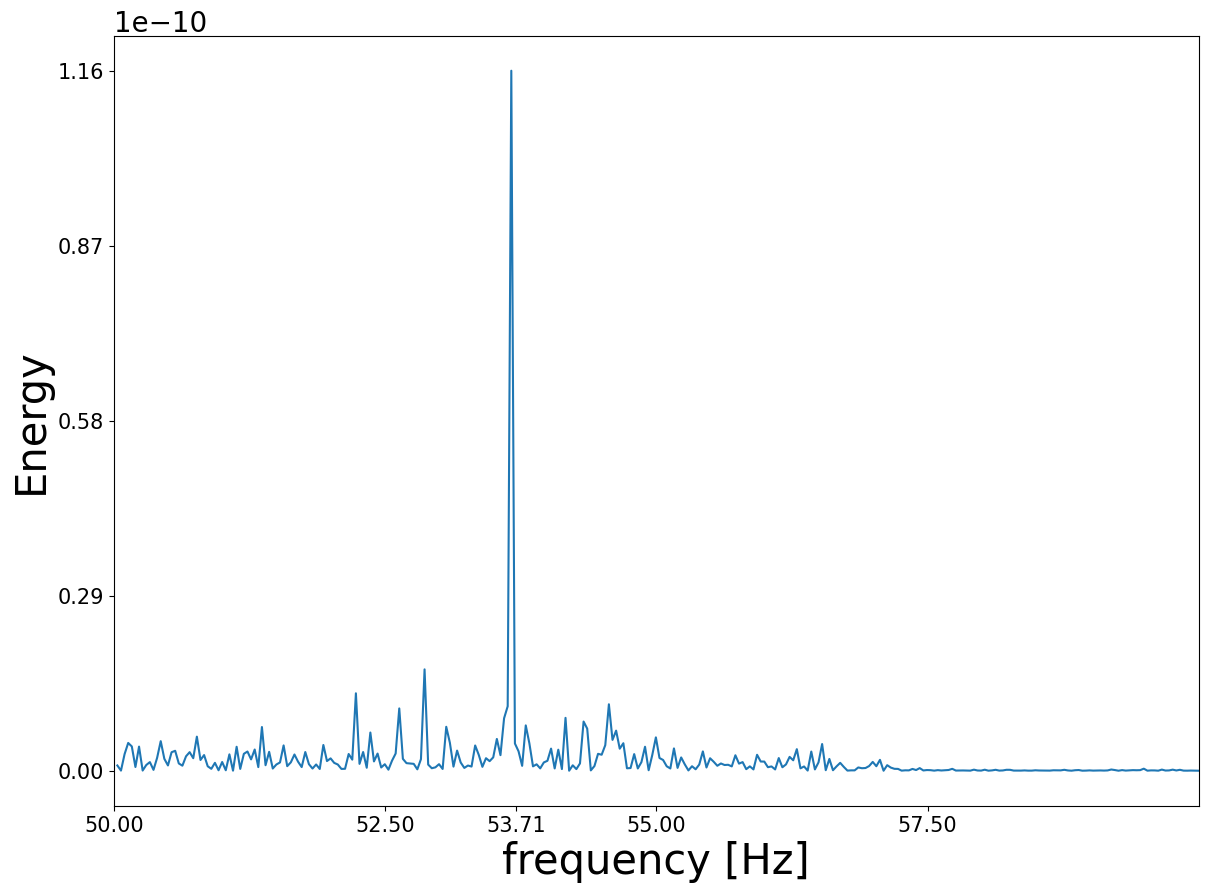

2023-04-16 17:50:03.588 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 3 - raw data
2023-04-16 17:50:03.589 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 3


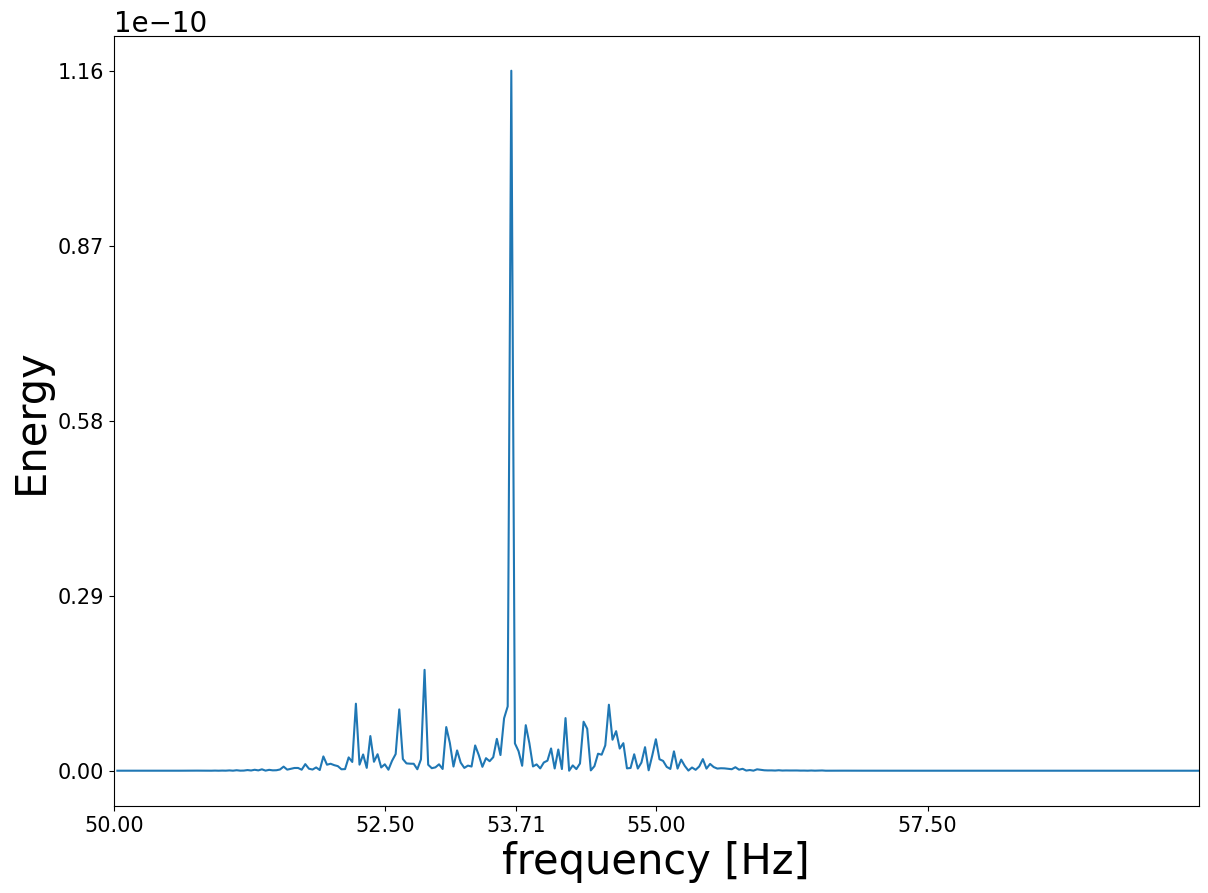

2023-04-16 17:50:03.877 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 3 - filtered data
2023-04-16 17:50:03.877 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 4


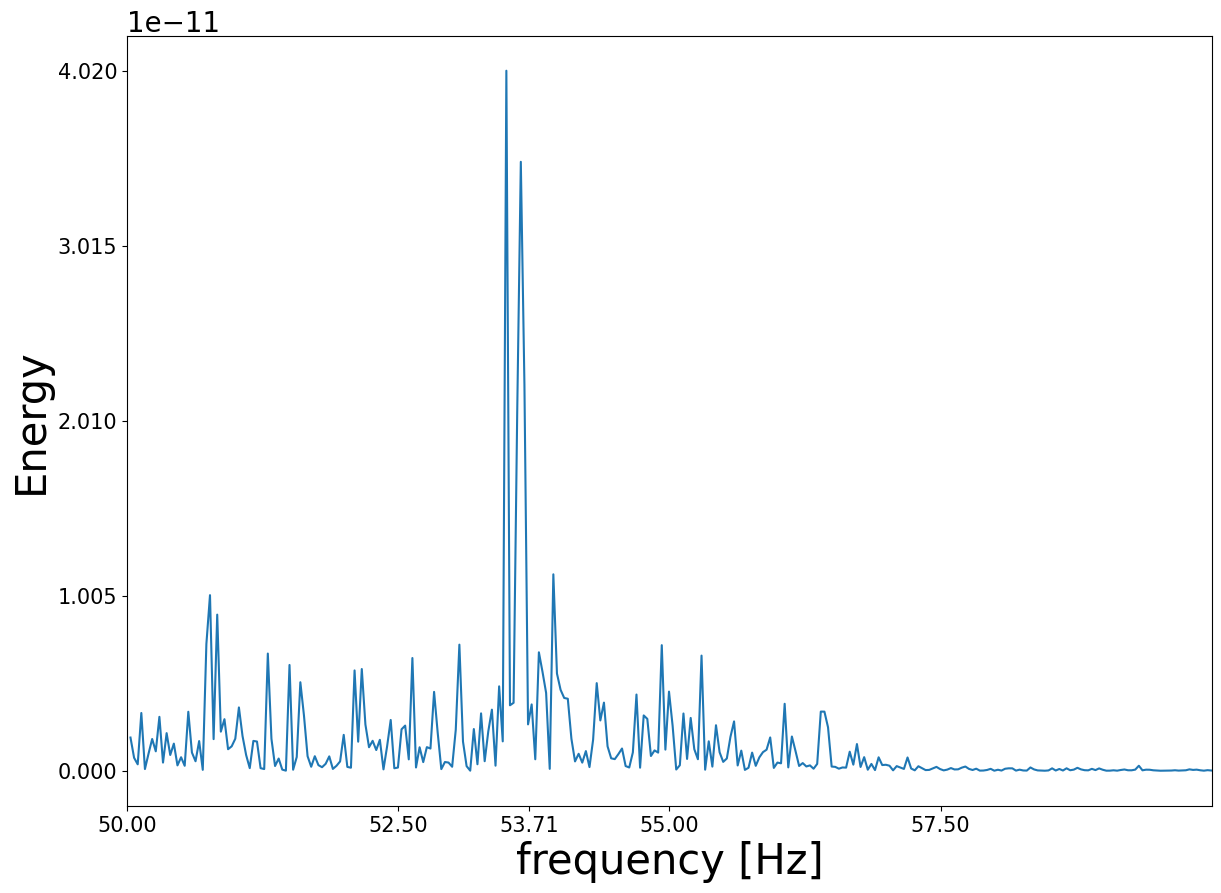

2023-04-16 17:50:04.080 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 4 - raw data
2023-04-16 17:50:04.081 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 4


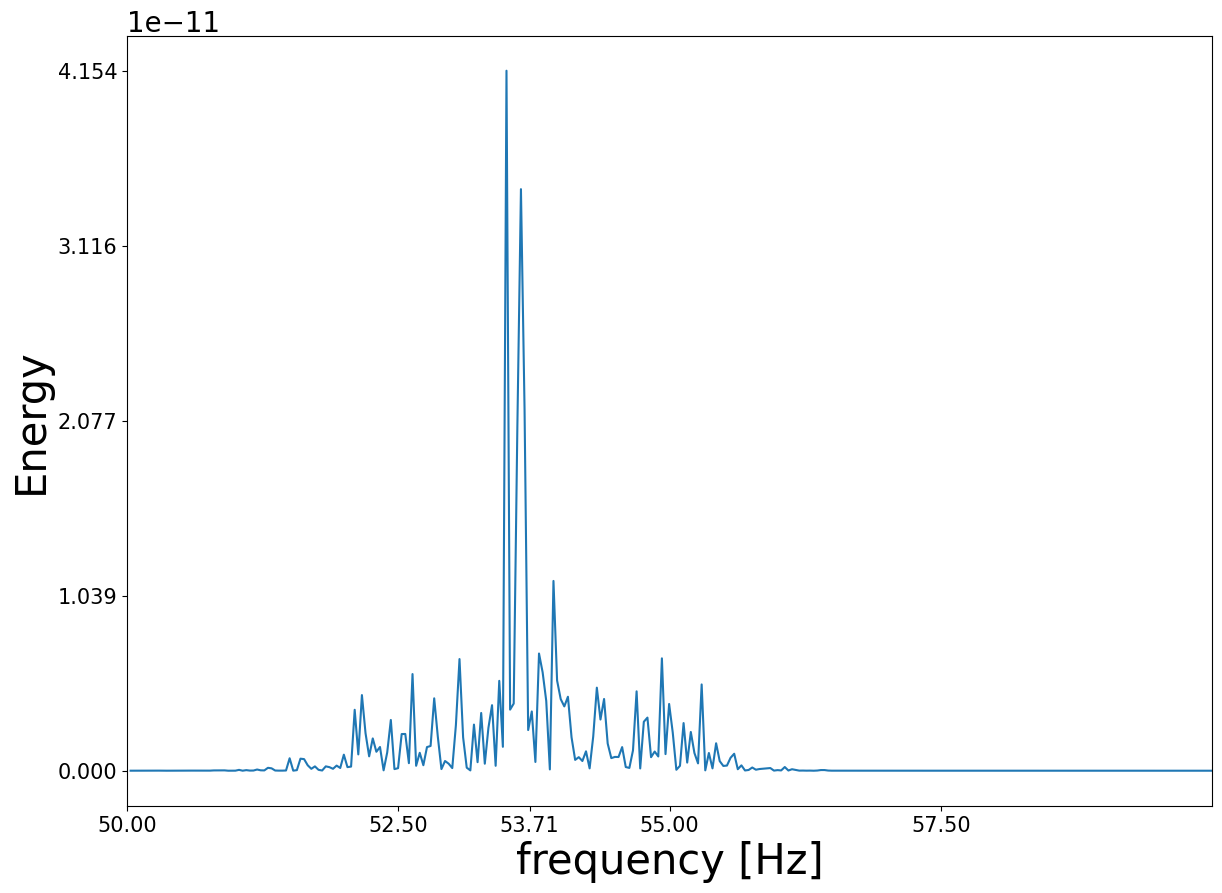

2023-04-16 17:50:04.294 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 4 - filtered data
2023-04-16 17:50:04.295 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 5


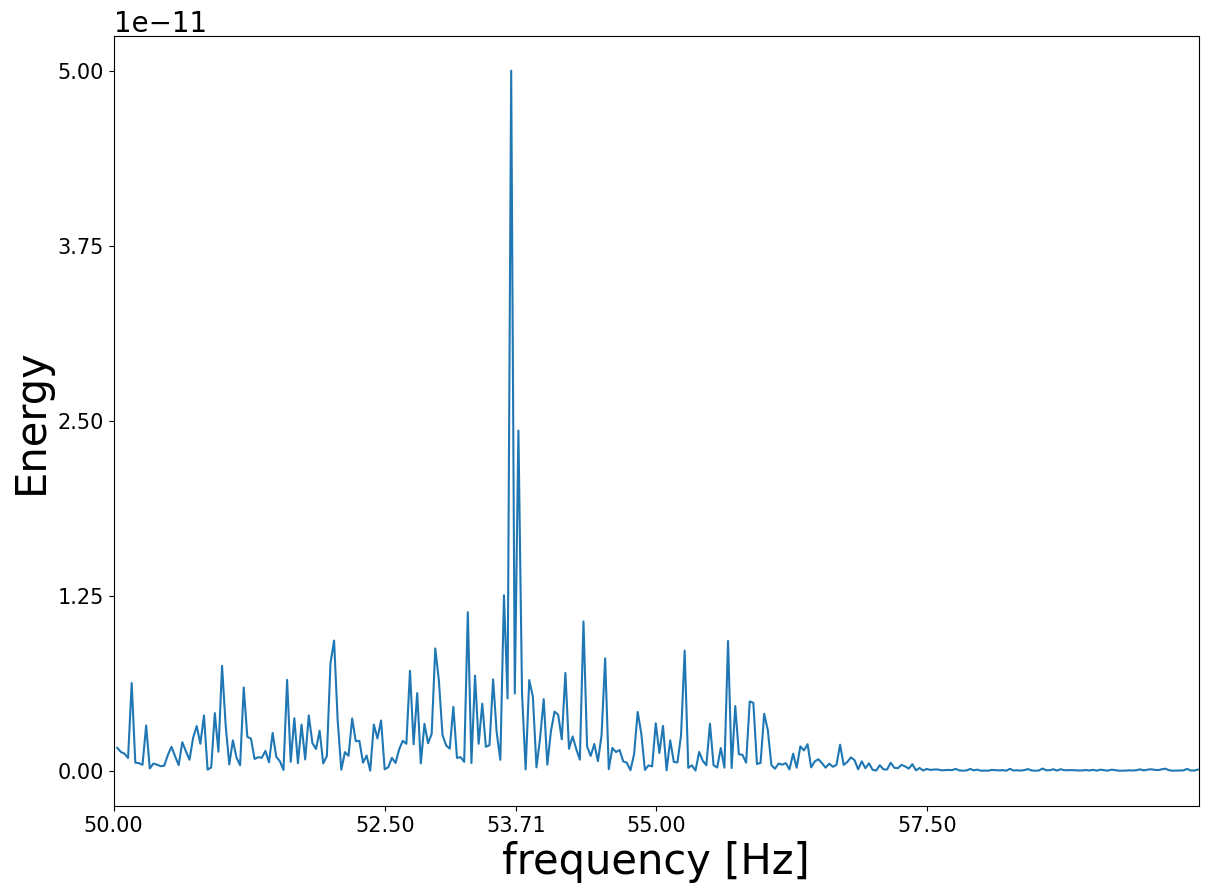

2023-04-16 17:50:04.505 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 5 - raw data
2023-04-16 17:50:04.506 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 5


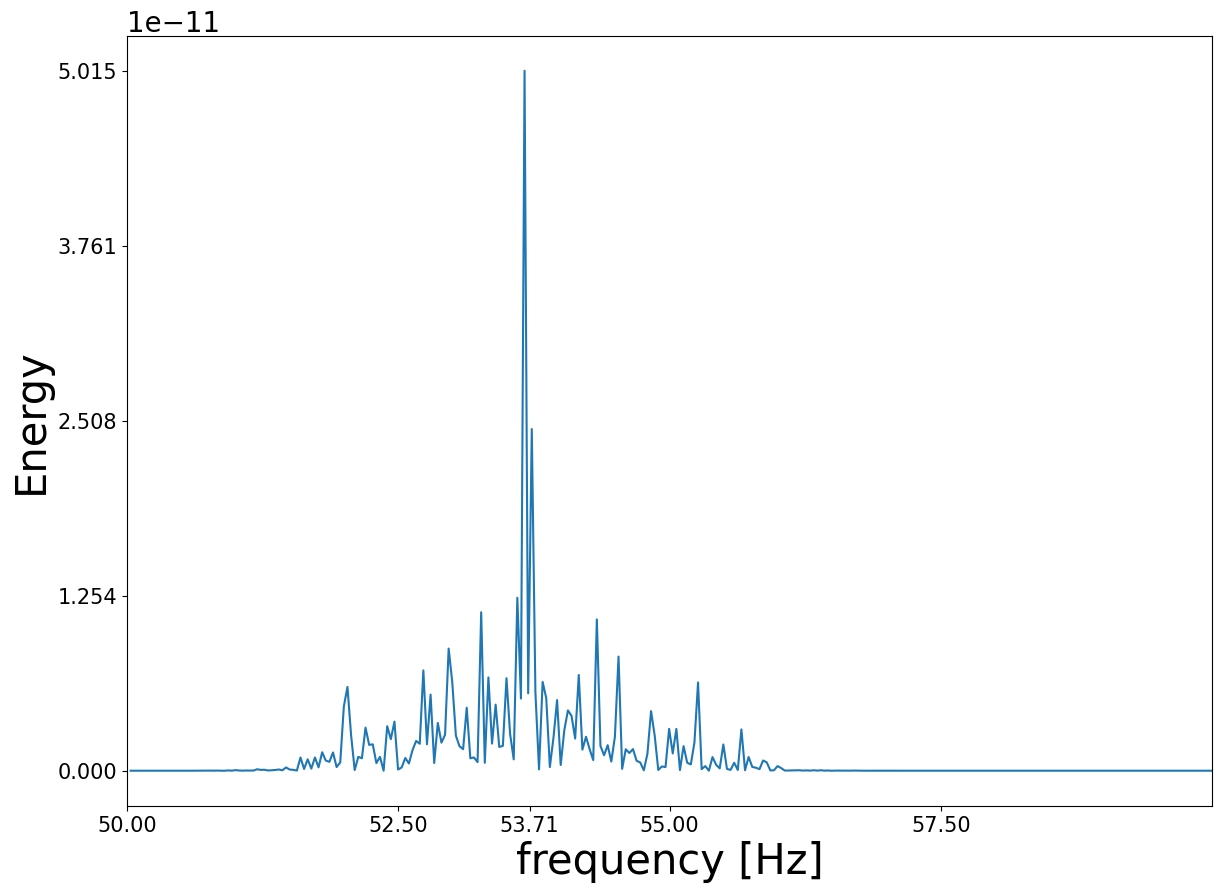

2023-04-16 17:50:04.713 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 5 - filtered data
2023-04-16 17:50:04.714 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 1


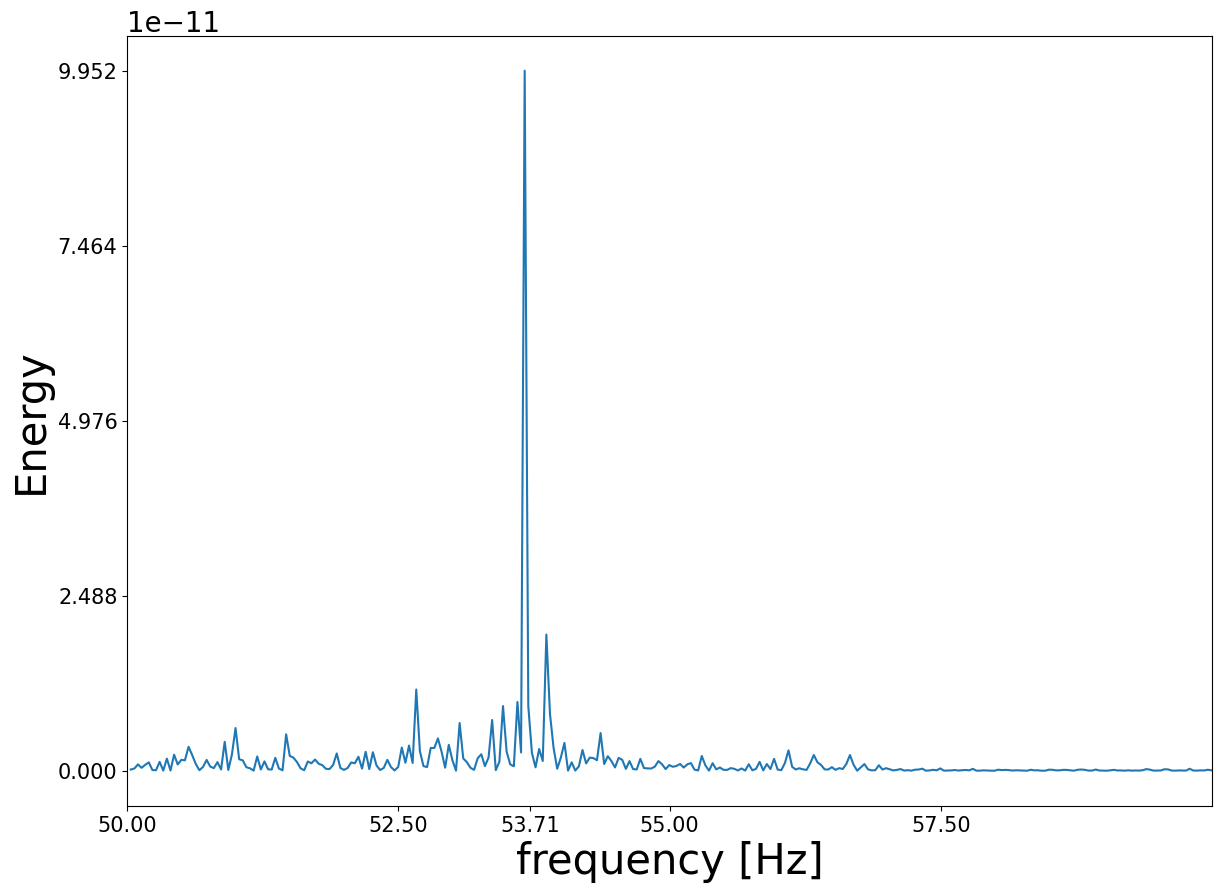

2023-04-16 17:50:04.913 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 1 - raw data
2023-04-16 17:50:04.913 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 1


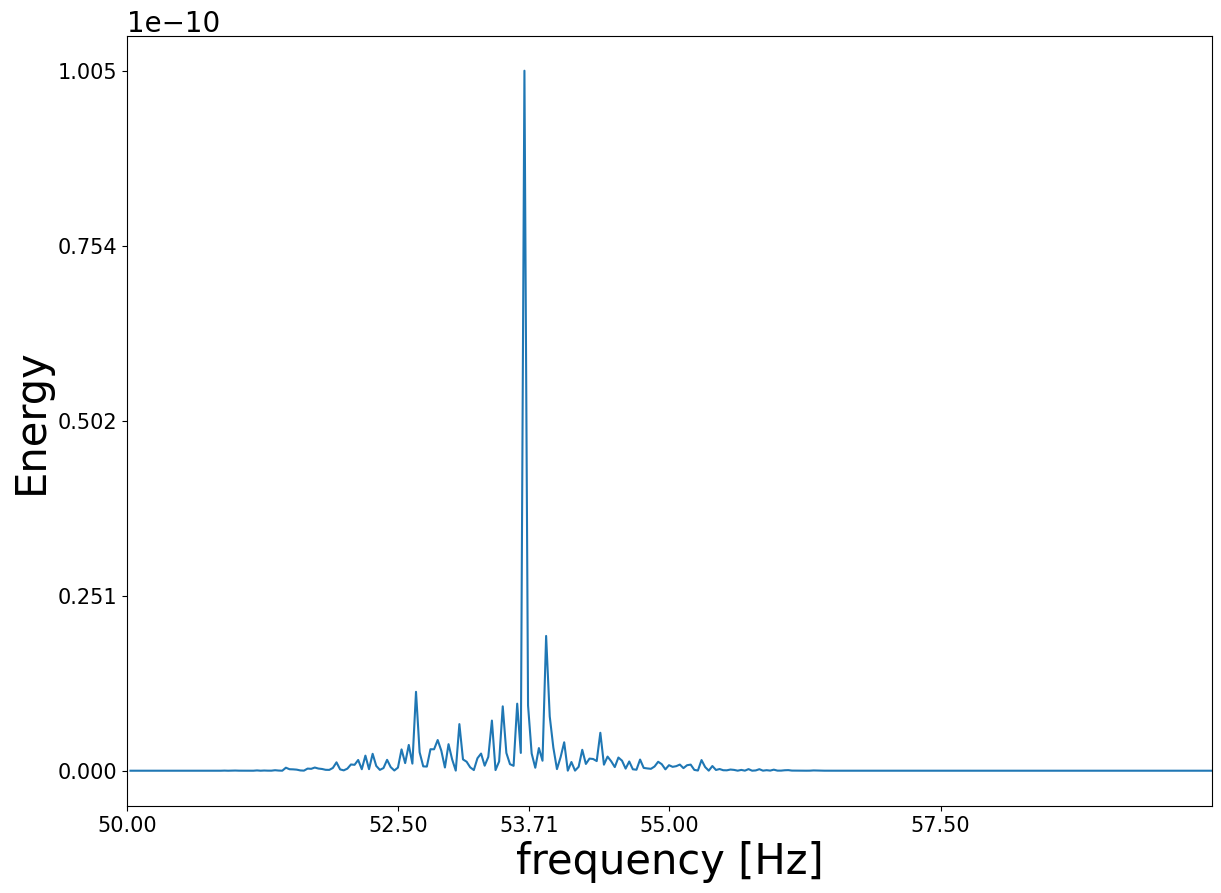

2023-04-16 17:50:05.120 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 1 - filtered data
2023-04-16 17:50:05.121 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 2


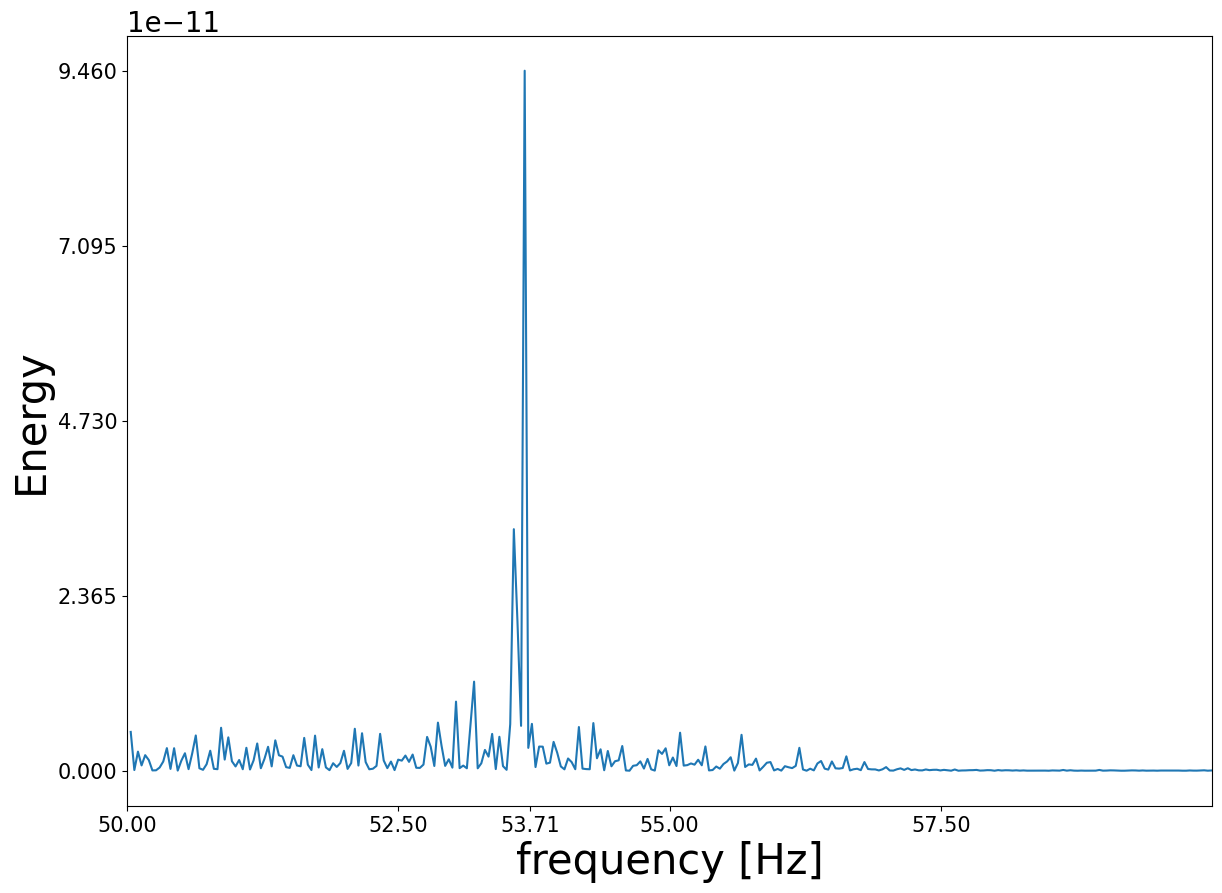

2023-04-16 17:50:05.317 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 2 - raw data
2023-04-16 17:50:05.318 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 2


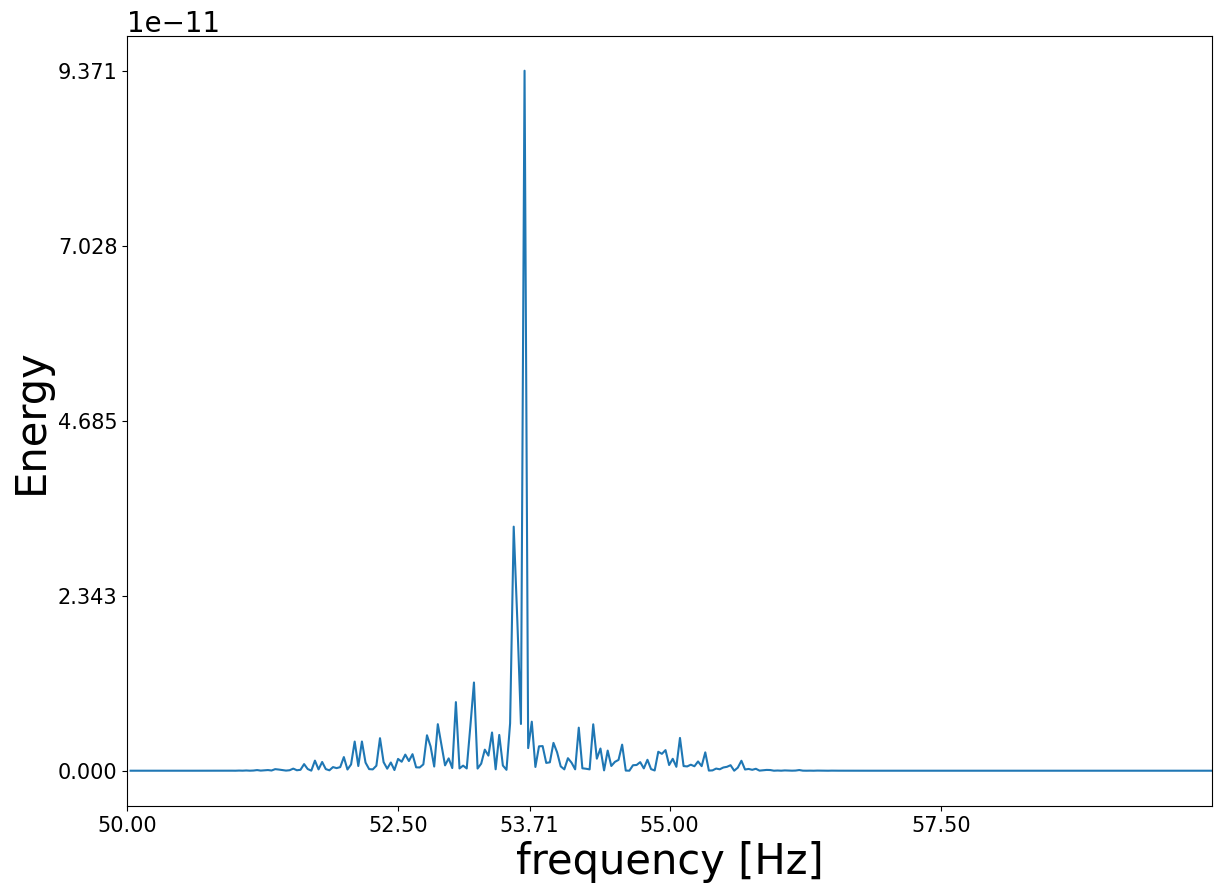

2023-04-16 17:50:05.524 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 2 - filtered data
2023-04-16 17:50:05.525 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 3


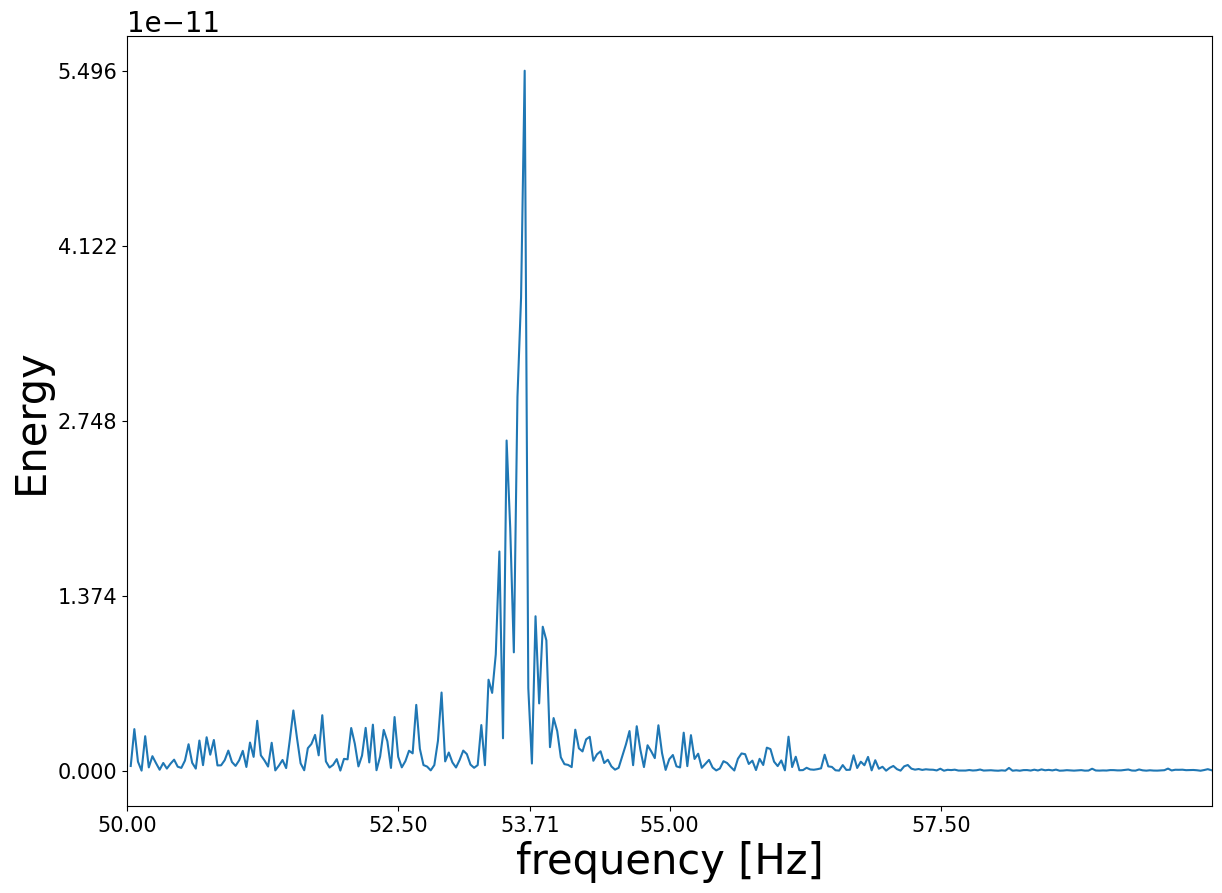

2023-04-16 17:50:05.727 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 3 - raw data
2023-04-16 17:50:05.727 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 3


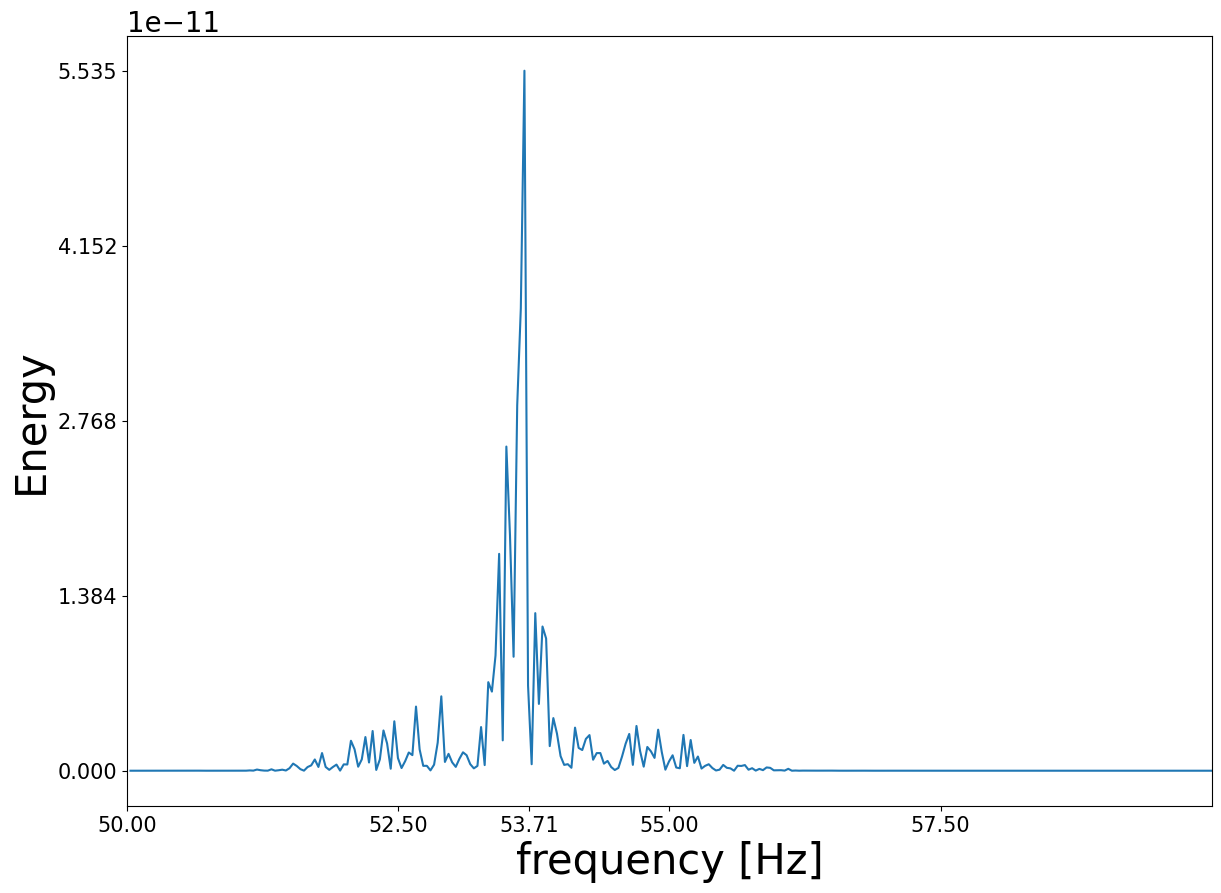

2023-04-16 17:50:05.924 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 3 - filtered data
2023-04-16 17:50:05.925 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 4


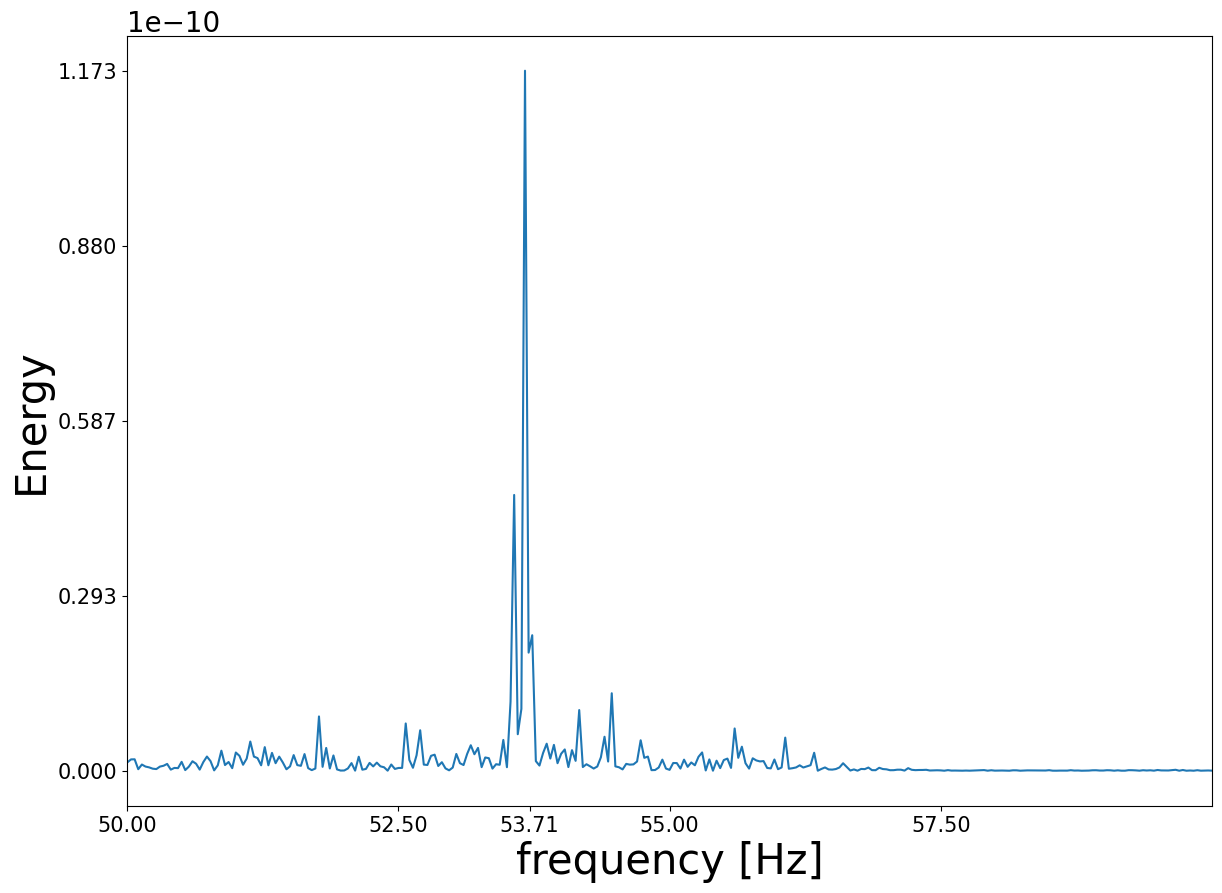

2023-04-16 17:50:06.129 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 4 - raw data
2023-04-16 17:50:06.129 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 4


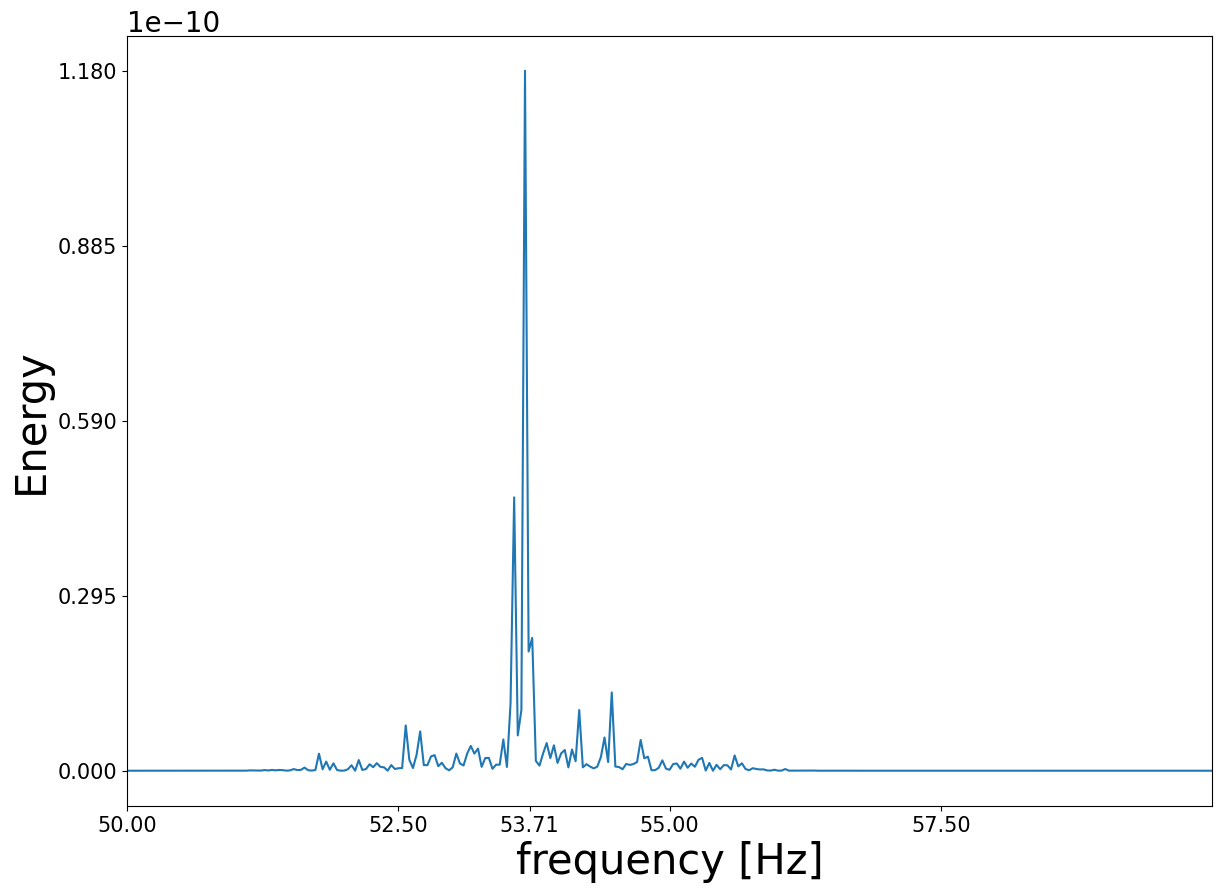

2023-04-16 17:50:06.343 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 4 - filtered data
2023-04-16 17:50:06.343 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 5


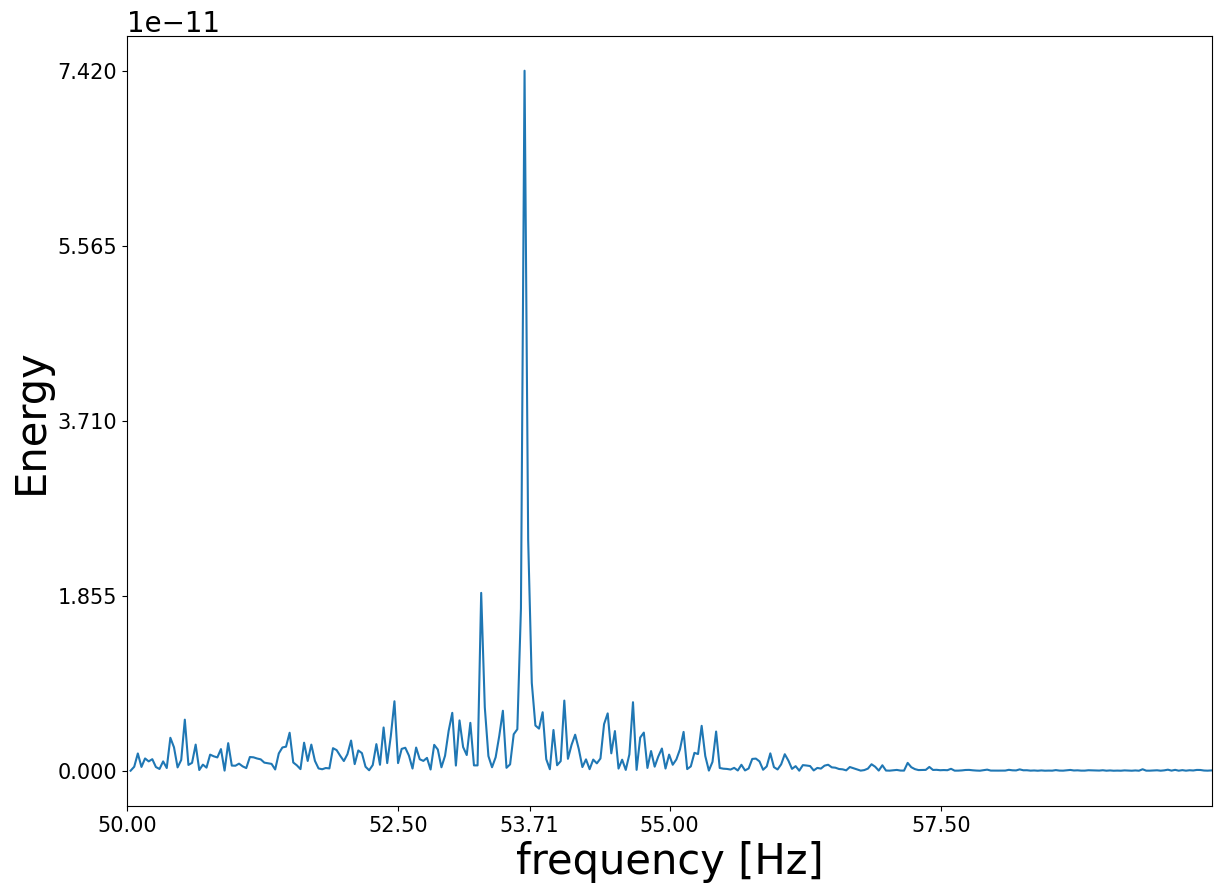

2023-04-16 17:50:06.547 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 5 - raw data
2023-04-16 17:50:06.547 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 5


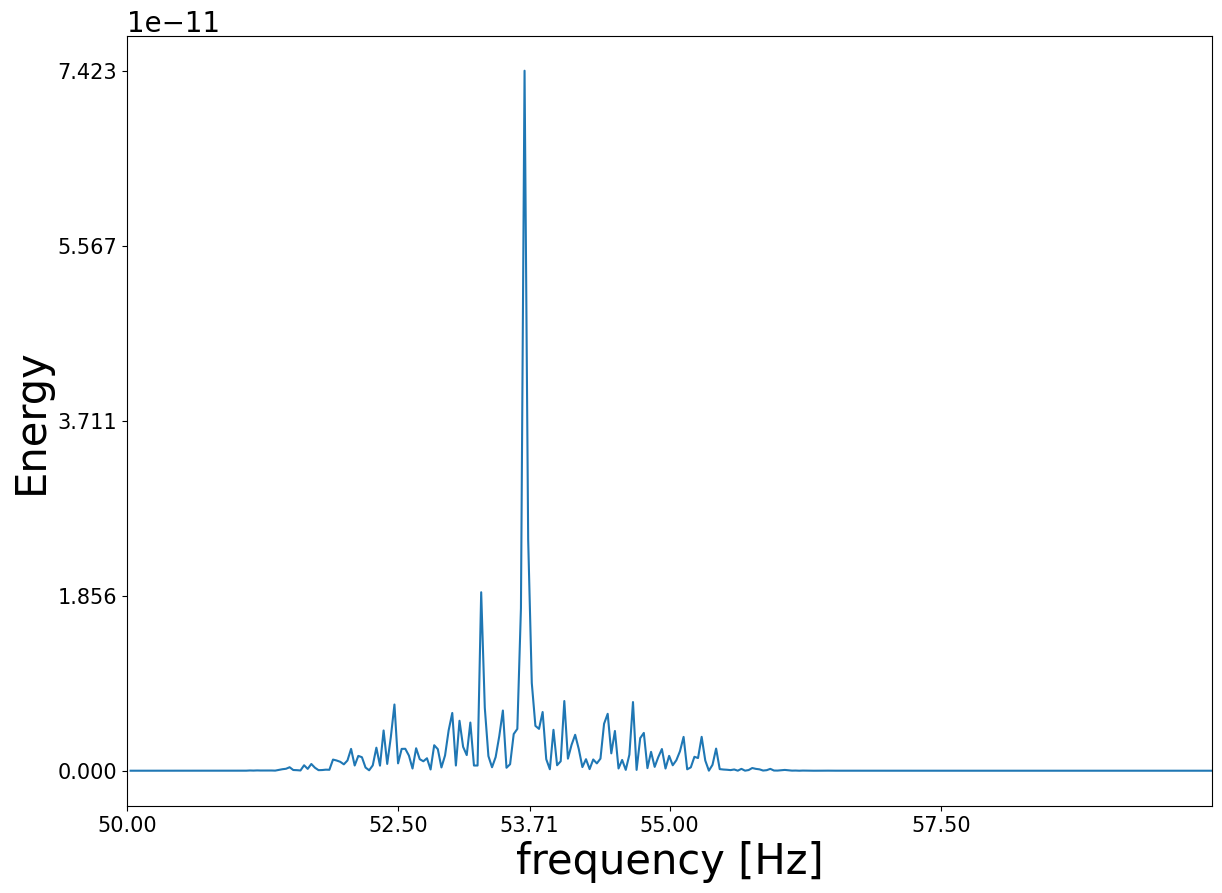

2023-04-16 17:50:06.748 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 5 - filtered data


In [42]:
sliding_window_size = 3.0

for name_data, data in {"train": data_train, "test": data_test}.items():
    for event_number in range(1, 6):
        for column in ["Inferior_colliculus", "filtered_Inferior_colliculus"]:
            
            logger.info(f'{name_data.capitalize()} Data - Selecting Event {event_number}')

            event_data = select_event_window(
                df=data, 
                event_name=f"event_{event_number}", 
                samples_before=0, 
                samples_after=0
            )
            
            frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)
            
            title = f'FFT_{name_data}_event_{event_number}_' + \
                f'{["raw", "filtered"][int(column.startswith("filtered"))]}.jpg'
            
            fig = plt.figure(figsize=(14,10))

            ax = fig.add_subplot(111)

            y = (intensity**2)[(frequency>=50)&(frequency<=60)]
            x = frequency[(frequency>=50)&(frequency<=60)]
            
            ax.plot(x, y)

            ax.set_xlabel("frequency [Hz]", fontsize=30)
            ax.set_ylabel('Energy', fontsize=30)
            t = ax.yaxis.get_offset_text()
            t.set_size(20)
            plt.xticks(np.sort(np.append(np.arange(50, 60, 2.5), [53.71])), fontsize=15)
            plt.yticks(np.linspace(min(y), max(y), 5), fontsize=15)
            plt.xlim([50, 60])
            plt.savefig(
                title,
                format="jpg",
                bbox_inches='tight', 
                dpi=150
            )
            
            plt.show()
            
            ax.clear()
            plt.close(fig)
            del frequency, intensity, angle
            
            logger.success(f'DONE: {name_data} Data - Event {event_number} - '+ \
            f'{["raw", "filtered"][int(column.startswith("filtered"))]} data')

# FFT

2023-04-16 18:07:28.245 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 1
2023-04-16 18:07:28.256 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 2
2023-04-16 18:07:28.264 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 3
2023-04-16 18:07:28.272 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 4
2023-04-16 18:07:28.282 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 5


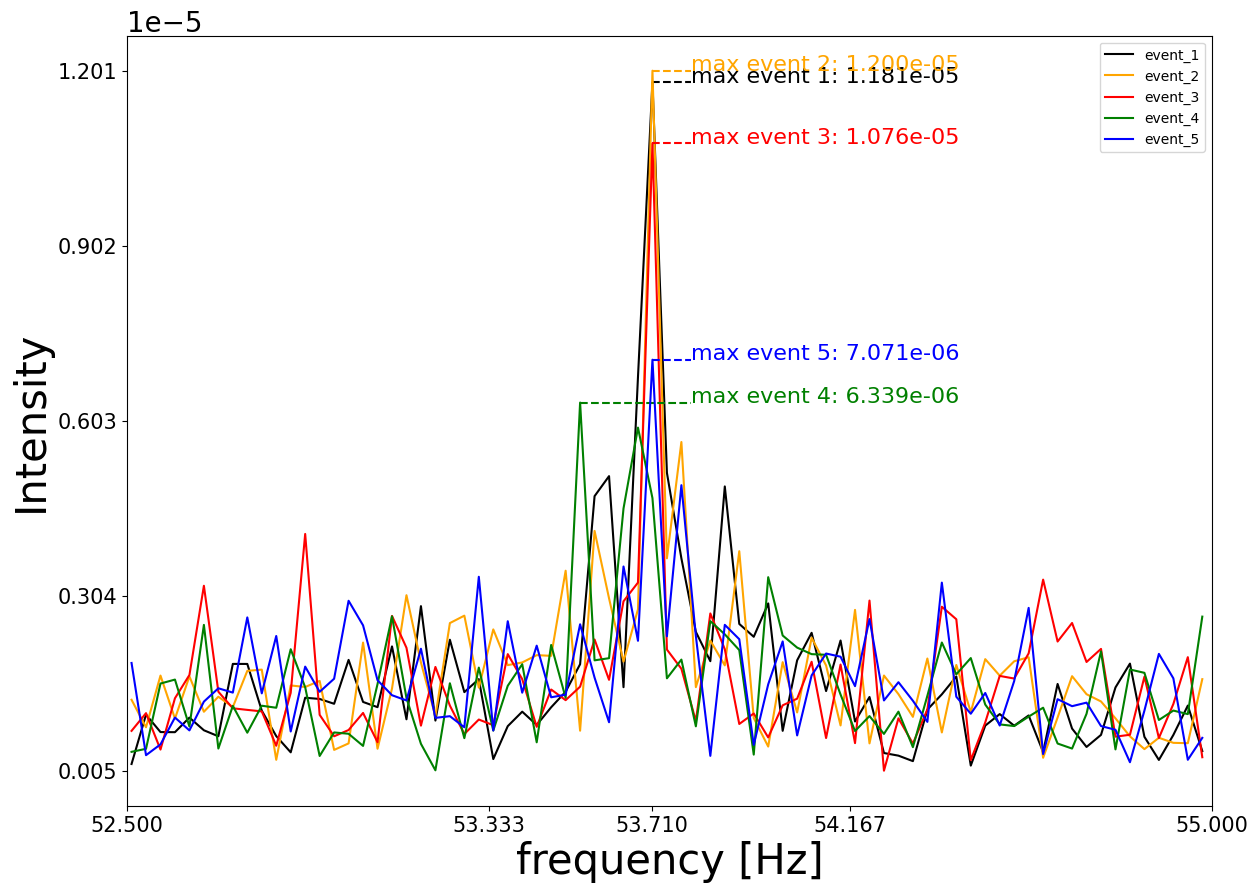

2023-04-16 18:07:28.587 | SUCCESS  | __main__:<module>:100 - DONE: train Data - Event 5 - raw data
2023-04-16 18:07:28.600 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 1
2023-04-16 18:07:28.609 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 2
2023-04-16 18:07:28.619 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 3
2023-04-16 18:07:28.628 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 4
2023-04-16 18:07:28.636 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 5


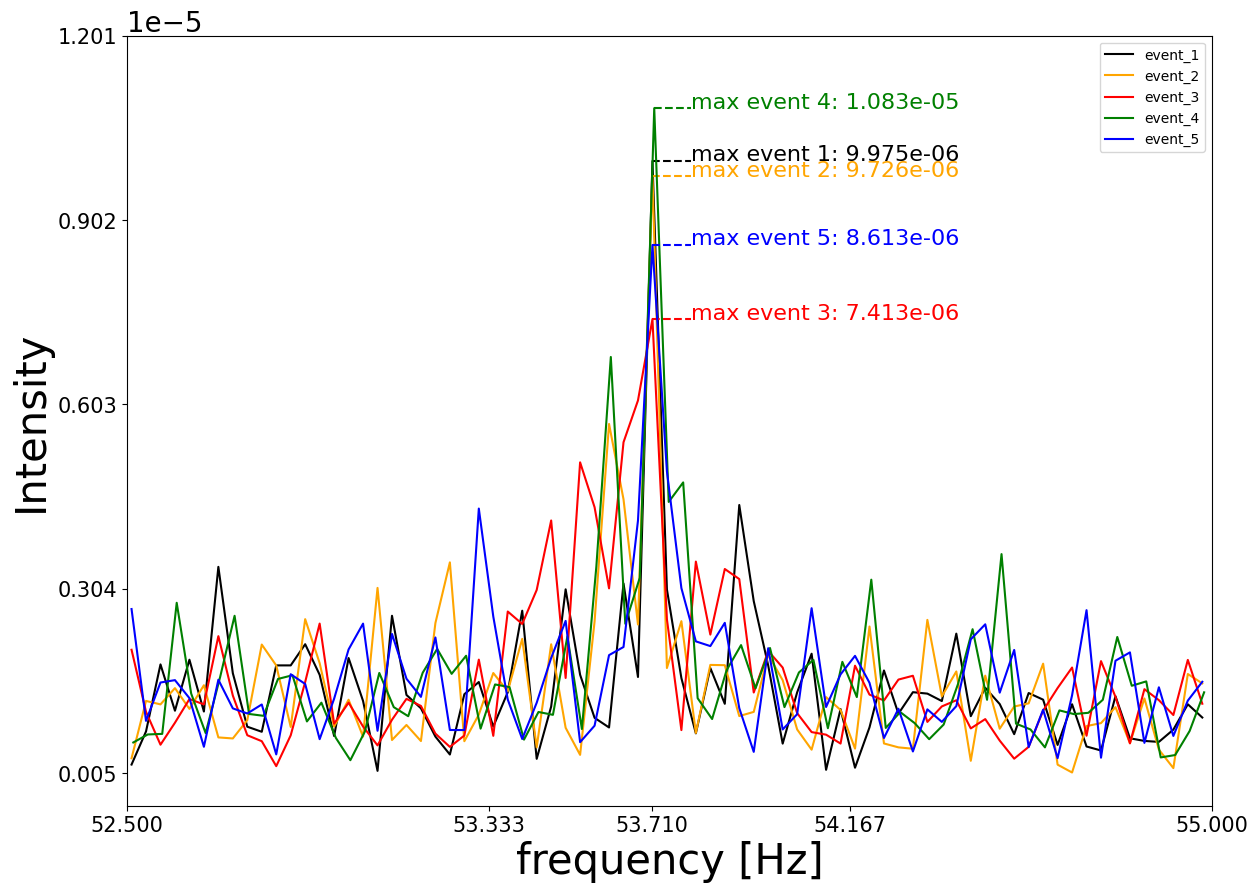

2023-04-16 18:07:28.957 | SUCCESS  | __main__:<module>:100 - DONE: test Data - Event 5 - raw data
/tmp/ipykernel_38500/3224471235.py:137: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  exponent = st.mode(exponents).mode[0]


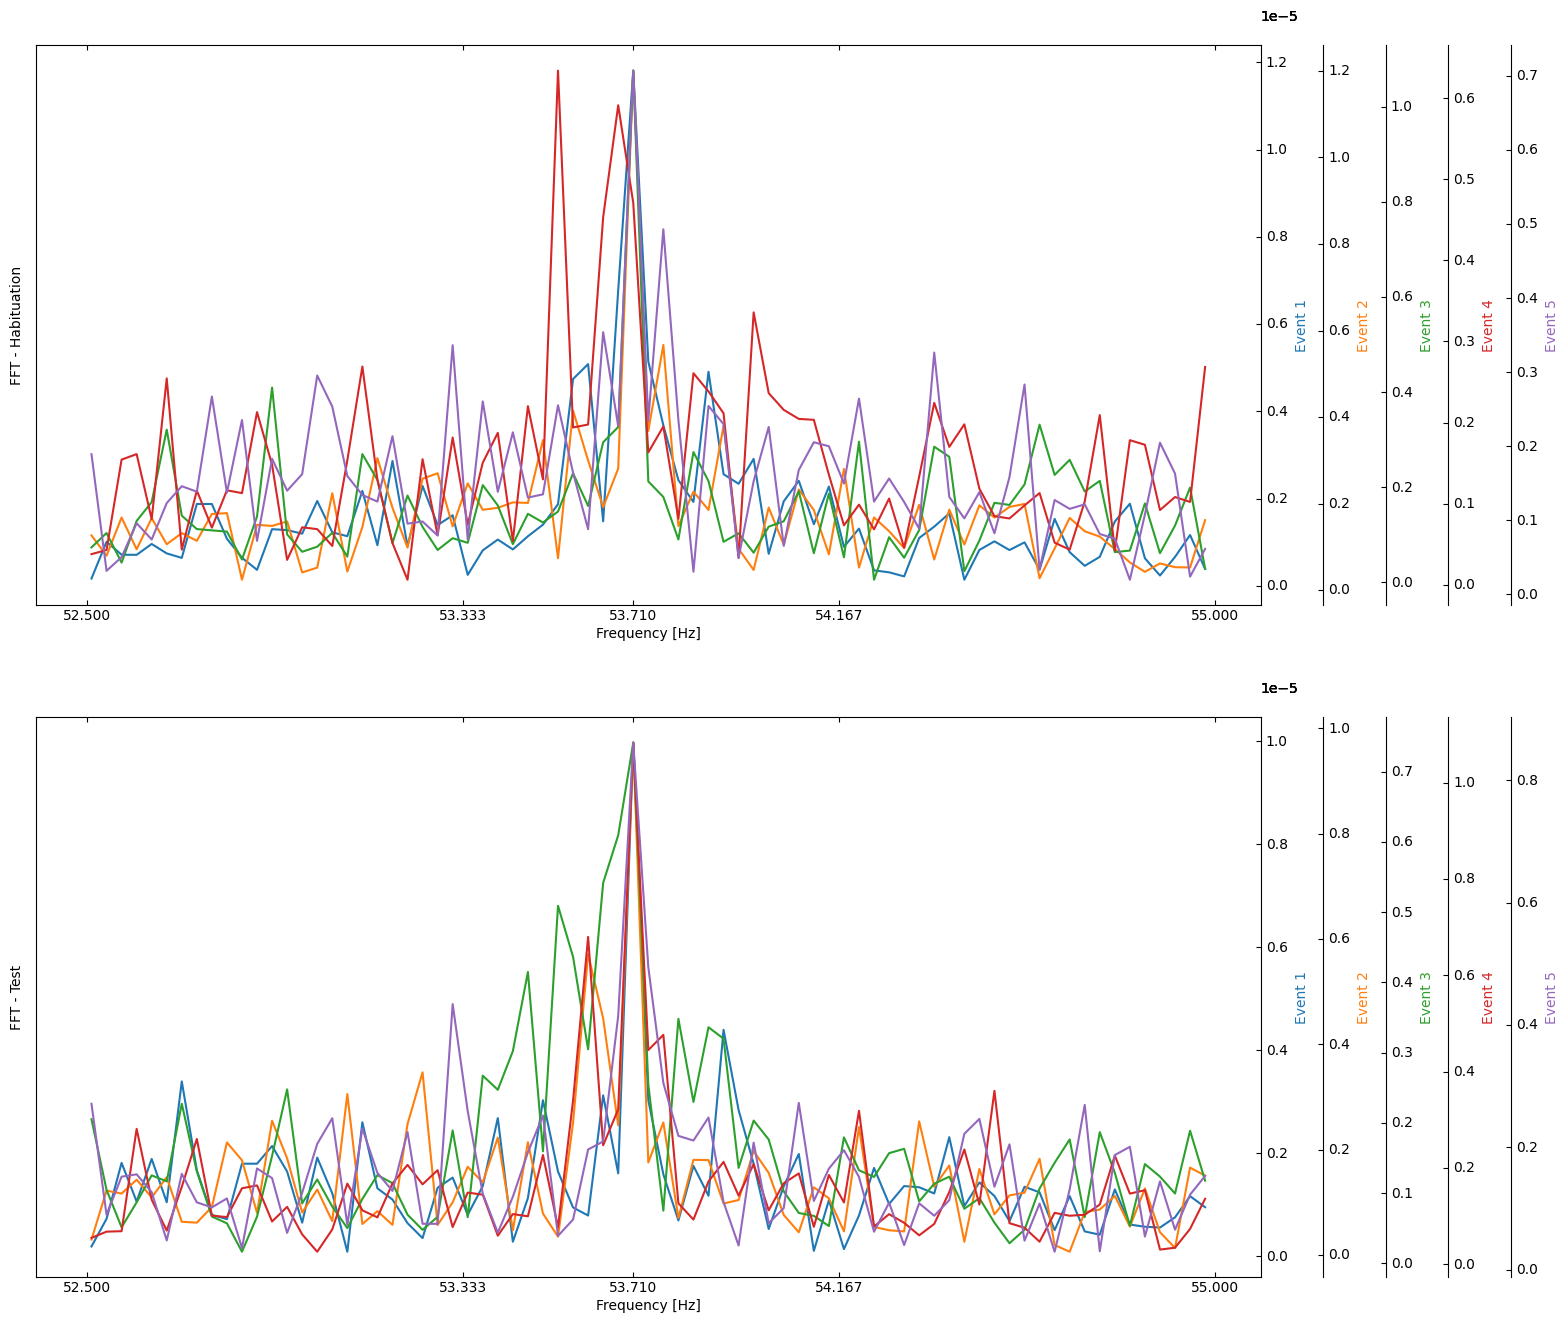

2023-04-16 18:07:29.818 | SUCCESS  | __main__:<module>:153 - Done plotting both experiments alongside!


In [51]:

plot_both = True
sliding_window_size = 3.0

lim = (52.5, 55)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

ffts = {
    "train": {
        "x": None,
        1: None,
        2: None,
        3: None,
        4: None,
        5: None
    },
    "test": {
        "x": None,
        1: None,
        2: None,
        3: None,
        4: None,
        5: None
    }
}

for name_data, data in {"train": data_train, "test": data_test}.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    for color, event_number in zip(colors, range(1, 6)):
        for column in ["Inferior_colliculus"]:
            
            logger.info(f'{name_data.capitalize()} Data - Selecting Event {event_number}')

            event_data = select_event_window(
                df=data, 
                event_name=f"event_{event_number}", 
                samples_before=0, 
                samples_after=0
            )
            
            frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)
            y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
            x = frequency[(frequency>=lim[0])&(frequency<=lim[1])]
            
            
            current_y_max = y.max()
            ymin = min(ymin, y.min())
            ymax = max(ymax, current_y_max)
            
            ax.plot(x, y, label=f"event_{event_number}", color=color)
            if ffts[name_data]["x"] is None:
                ffts[name_data]["x"] = x
            ffts[name_data][event_number] = y

            ftext = str(current_y_max).split('.')[0] + "." + \
                    str(current_y_max).split('.')[1].split('e')[0][:3] + "e" + \
                    str(current_y_max).split('.')[1].split('e')[1]
            
            # place a text box in upper left in axes coords
            ax.text(
                53.8, 
                current_y_max, 
                f"max event {event_number}: {ftext}", 
                fontsize=16, 
                color=color
            )
            
            plt.plot(
                [x[np.argwhere(y==current_y_max)[0][0]], 53.8], 
                [current_y_max]*2, 
                '--', 
                color=color
            )
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.yticks(np.linspace(ymin, ymax, 5), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend()
    plt.savefig(
        f"all_FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()
    
    
    logger.success(f'DONE: {name_data} Data - Event {event_number} - '+ \
    f'{["raw", "filtered"][int(column.startswith("filtered"))]} data')

    
# ------------------------------------------------------------------------------------------
if plot_both:
    
    number_of_axis = 5
    offset = 45
    fig_axis = plt.figure(figsize=(14, 16))
    for line, experiment, experiment_description in zip([1, 2], ["train", "test"], ["Habituation", "Test"]):
        host = host_subplot(int(f"21{line}"), axes_class=AA.Axes, figure=fig_axis)
        plt.subplots_adjust(right=1)

        axis = [host.twinx() for _ in range(number_of_axis)]

        host.set_ylabel(f"FFT - {experiment_description}")
        host.set_xlabel("Frequency [Hz]")
        host.set_yticks([], [])

        for i, par in enumerate(axis):
            if i > 0:
                new_fixed_axis = par.get_grid_helper().new_fixed_axis
                par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                                    offset=((i)*offset, 0))

            par.axis["right"].toggle(all=True)

            par.set_ylabel(f"Event {1+i}")

            p, = par.plot(ffts[experiment]["x"], ffts[experiment][i+1], label=f"event_{i+1}")

            par.axis["right"].label.set_color(p.get_color())

        plt.draw()

        exponents = [int(par._axislines['right'].offsetText._text.split('e')[1].replace('−', '-')) for par in axis]
        exponent = st.mode(exponents).mode[0]

        for i, par in enumerate(axis):
            par.ticklabel_format(axis='y', style='sci', scilimits=(exponent, exponent), useOffset=False)
            par.set_xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])))
    
    plt.draw()
    
    plt.savefig(
        f"all_FFT_{name_data}_scaled.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=100
    )
    plt.show()
    
    logger.success("Done plotting both experiments alongside!")


## Espectro/Bispectro/Trispectro

In [44]:
data_dict = {
    "train": data_train,
    "test": data_test
}

hosa_train = None
hosa_test = None

for data_to_process in ("train", "test"):

    id_results: str = f"rato-{rat_number}-grupo-{group_number}-{data_to_process}"

    # Select the configuration to run the script, by commenting/uncommenting and changing the lines below

    # Configuration 1: Frequency array
#     frequency_array = np.append(
#         np.arange(start=4, stop=10, step=0.01), 
#         np.arange(start=51.71, stop=55.71, step=0.01)
#     )
    
    frequency_array = np.arange(start=51.71, stop=55.71, step=0.01)
    
    TDTS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    
    data = data_dict[data_to_process]

    events = data.event.unique()
    events = events[events != "base"]

    logger.info(f"Events in the data: {events}")

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()

    logger.info("Processing the tdts... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    time = data.Time.to_numpy()
    TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
    FrequencySampling = 1.0/TimeSampling

    tdts_object = TDTS(
        frequency_sampling=FrequencySampling,
        time=None,
        frequency_array=TDTS_PARAMETERS.get("frequency_array"),
        fmin=TDTS_PARAMETERS.get("fmin"),
        fmax=TDTS_PARAMETERS.get("fmax"),
        freq_step=TDTS_PARAMETERS.get("freq_step"),
        phase_step=TDTS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdts_object.run_tbds(x)

    with Pool() as pool:

        for result in pool.map(f, [{event: select_event_window(
            df=data,
            event_name=event,
            samples_before=0,
            samples_after=0
        ).loc[:, "Inferior_colliculus"].to_numpy()} for event in events]):

            event, result_data = list(result.items())[0]
            frequency_array, spectrum, phase_spectrum, bispectrum, phase_bispectrum, trispectrum, phase_trispectrum = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{event}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{event}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{event}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{event}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{event}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{event}": phase_trispectrum})


    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    if data_to_process == "train":
        hosa_train = hosa_df
    elif data_to_process == "test":
        hosa_test = hosa_df
        
    hosa_df.to_csv(f'{BASE_PATH}/hosa_{id_results}_{"-".join(str(pendulum.today()).split("T")[0].split("-")[::-1])}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing {data_to_process} data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-04-16 17:50:08.343 | INFO     | __main__:<module>:34 - Events in the data: ['event_1' 'event_2' 'event_3' 'event_4' 'event_5']
2023-04-16 17:50:08.344 | INFO     | __main__:<module>:39 - Processing the tdts... This may take a while...

 99% (250971 of 251600) |############### | Elapsed Time: 0:00:51 ETA:   0:00:002023-04-16 17:50:59.764 | SUCCESS  | __main__:<module>:96 - Done processing train data. Elapsed time: 51s
2023-04-16 17:50:59.775 | INFO     | __main__:<module>:34 - Events in the data: ['event_1' 'event_2' 'event_3' 'event_4' 'event_5']
2023-04-16 17:50:59.776 | INFO     | __main__:<module>:39 - Processing the tdts... This may take a while...

 99% (250971 of 251600) |############### | Elapsed Time: 0:00:51 ETA:   0:00:002023-04-16 17:51:51.857 | SUCCESS  | __main__:<module>:96 - Done processing test data. Elapsed time: 52s


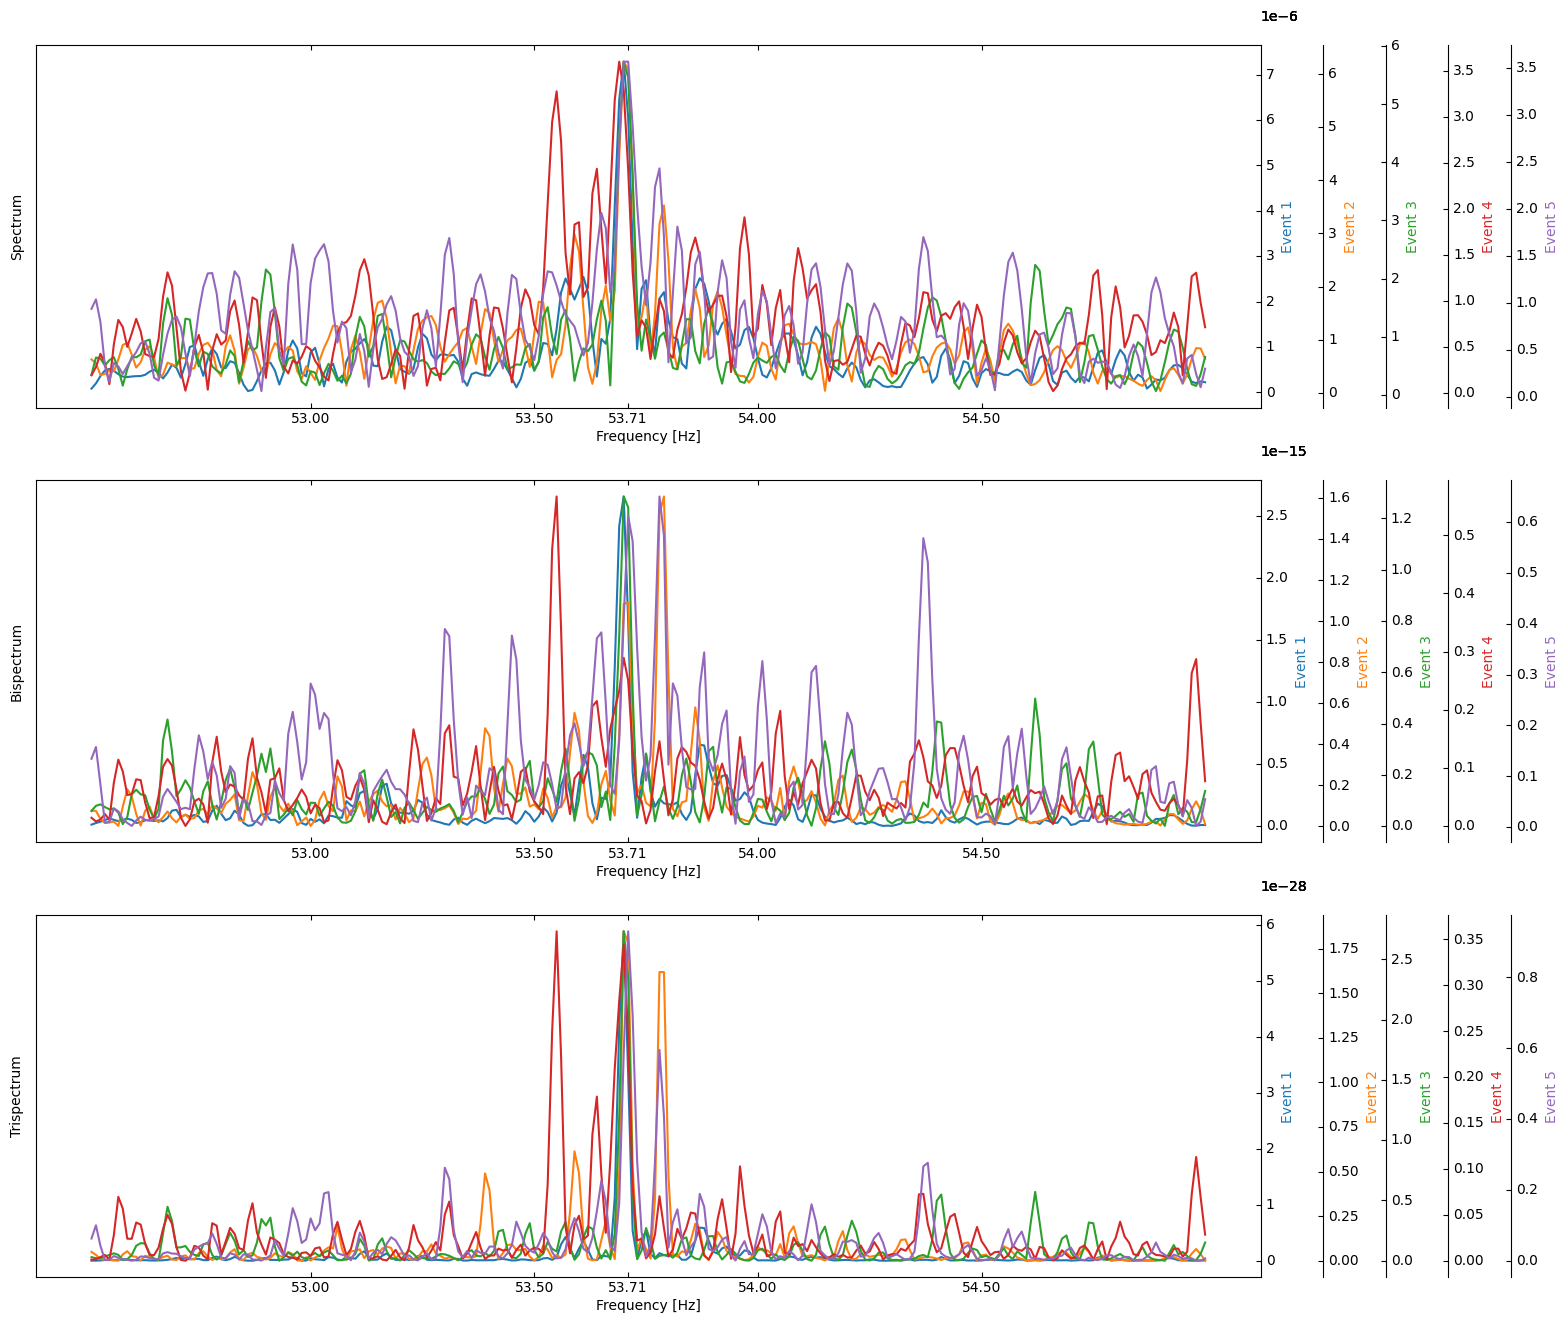

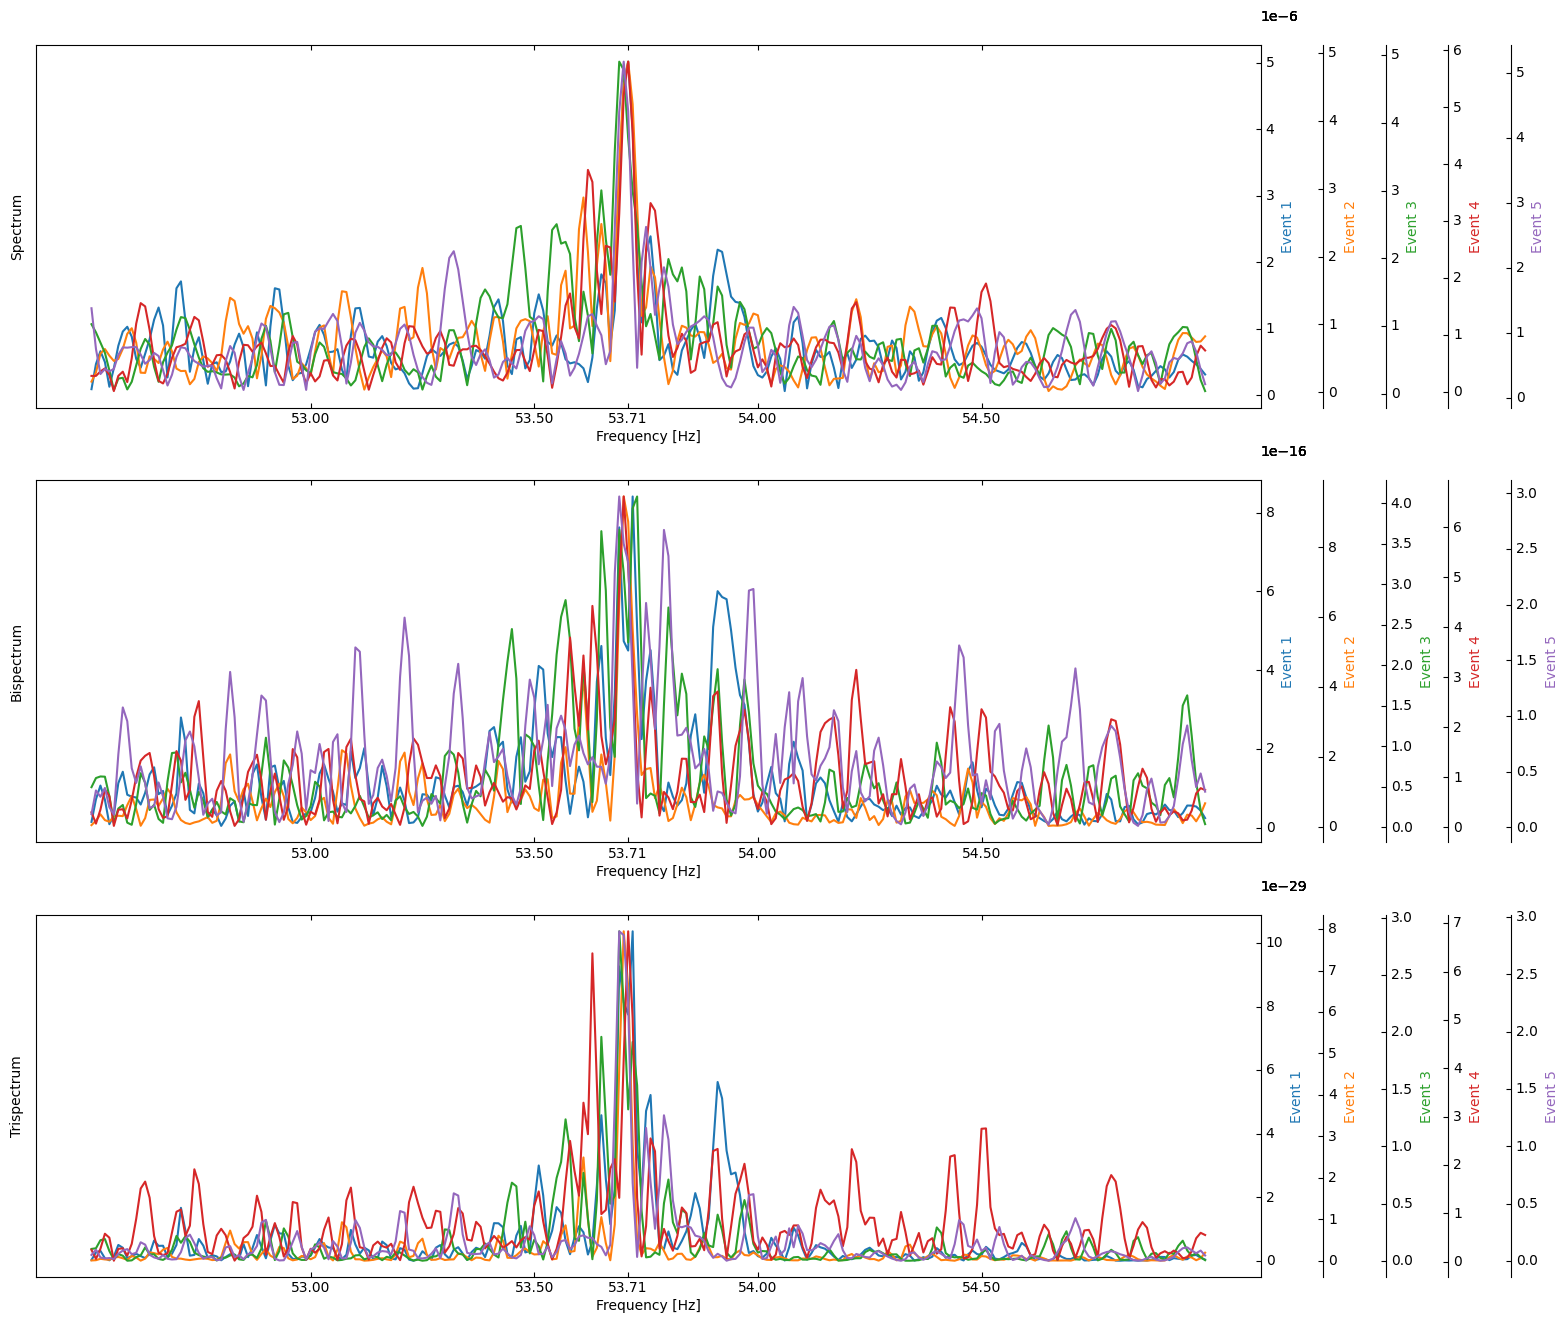

In [49]:
standardize = False
plotly_plot = False
plt_scaled_plot = True

for data_to_process, df in {"train": hosa_train, "test": hosa_test}.items():

    band_to_plot = (52.5, 55)

    df = df[(df.iloc[:, 0]>=band_to_plot[0])&(df.iloc[:, 0]<=band_to_plot[1])]

    spectrum_colum_amp = [column for column in df.columns if column.startswith("tds_amp")]
    bispectrum_colum_amp = [column for column in df.columns if column.startswith("tdbs_amp")]
    trispectrum_colum_amp = [column for column in df.columns if column.startswith("tdts_amp")]

    amplitudes_df = df.loc[:, spectrum_colum_amp + bispectrum_colum_amp + trispectrum_colum_amp]
    if standardize:
        amplitudes_df = amplitudes_df.apply(lambda x: standardize_array(x, scale_to_unit=True))

    spectrum_colum_phase = [column for column in df.columns if column.startswith("tds_phase")]
    bispectrum_colum_phase = [column for column in df.columns if column.startswith("tdbs_phase")]
    trispectrum_colum_phase = [column for column in df.columns if column.startswith("tdts_phase")]

    phases_df = df.loc[:, spectrum_colum_phase + bispectrum_colum_phase + trispectrum_colum_phase]

    title = f"HOSA-rato-{rat_number}-grupo-{group_number}-{data_to_process}"
    
    if plotly_plot:
        fig = make_subplots(rows=3, cols=1)

        fig.update_layout(
            font_family="Courier New",
            font_color="blue",
            title_font_family="Times New Roman",
            title_font_color="black",
            legend_title_font_color="green",
            title=f"Amplitude - {title}"
        )

        amplitudes = px.line(amplitudes_df, x=df.iloc[:, 0], y=amplitudes_df.columns)

    ymin_spectrum = float('inf')
    ymax_spectrum = float('-inf')

    ymin_bispectrum = float('inf')
    ymax_bispectrum = float('-inf')

    ymin_trispectrum = float('inf')
    ymax_trispectrum = float('-inf')
    if plotly_plot:
        for amplitude in amplitudes['data']:
            i = 1*(amplitude.legendgroup.startswith("tds")) + \
            2 * (amplitude.legendgroup.startswith("tdbs")) + \
            3 * (amplitude.legendgroup.startswith("tdts"))
            
            fig.add_trace(amplitude, row=i, col=1)

            ax = (ax1, ax2, ax3)[i-1]

            if i == 1:
                ymin_spectrum = min(ymin_spectrum, np.min(amplitude.y))
                ymax_spectrum = max(ymax_spectrum, np.max(amplitude.y))
            elif i == 2:
                ymin_bispectrum = min(ymin_bispectrum, np.min(amplitude.y))
                ymax_bispectrum = max(ymax_bispectrum, np.max(amplitude.y))
            elif i == 3:
                ymin_trispectrum = min(ymin_trispectrum, np.min(amplitude.y))
                ymax_trispectrum = max(ymax_trispectrum, np.max(amplitude.y))
            if plt_plot:
                ax.plot(amplitude.x, amplitude.y, label=amplitude.legendgroup)
        fig.show()
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------   

    
    if plt_scaled_plot:
        
        plots_dict = {}
        
        for column in df.columns:
            
            if ("phase" in column) or ("frequency" in column):
                continue
                
            if column.startswith("tds"):
                experiment = "Spectrum"
            elif column.startswith("tdbs"):
                experiment = "Bispectrum"
            elif column.startswith("tdts"):
                experiment = "Trispectrum"
            
            if experiment not in plots_dict:
                plots_dict[experiment] = {}
                
            plot_number = int(column[-1]) - 1
            
            plots_dict[experiment][plot_number] = column
                
        number_of_axis = 5
        offset = 45
        fig_axis = plt.figure(figsize=(14, 16))
        lines = [1, 2, 3]
        experiments = ["Spectrum", "Bispectrum", "Trispectrum"]

        ticks = np.sort(np.append(53.71, np.linspace(band_to_plot[0], band_to_plot[1], 6)))[1:-1]
        for line, experiment in zip(lines, experiments):
            
            host = host_subplot(int(f"31{line}"), axes_class=AA.Axes, figure=fig_axis)
            plt.subplots_adjust(right=1)

            axis = [host.twinx() for _ in range(number_of_axis)]

            host.set_ylabel(experiment, fontsize=15)
            host.set_xlabel("Frequency [Hz]")
            host.set_yticks([], [])

            for i, par in enumerate(axis):
                if i > 0:
                    new_fixed_axis = par.get_grid_helper().new_fixed_axis
                    par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                                        offset=((i)*offset, 0))

                par.axis["right"].toggle(all=True)

                par.set_ylabel(f"Event {(i%5)+1}")
                
                par.set_xticks(ticks)

                p, = par.plot(df.frequency, df.loc[:, plots_dict[experiment][i]])

                par.axis["right"].label.set_color(p.get_color())

            plt.draw()

            exponents = [int(par._axislines['right'].offsetText._text.split('e')[1].replace('−', '-')) for par in axis]
            exponent = st.mode(exponents, keepdims=False).mode

            for i, par in enumerate(axis):
                par.ticklabel_format(axis='y', style='sci', scilimits=(exponent, exponent), useOffset=False)

        plt.draw()

        plt.savefig(
            f"all_FFT_{name_data}_scaled.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=100
        )
        plt.show()

In [54]:
del amplitudes_df
del bispectrum
del bispectrum_colum_amp
del bispectrum_colum_phase
del phase_spectrum
del phase_bispectrum
del phase_trispectrum
del phases_df
del trispectrum
del trispectrum_colum_amp
del trispectrum_colum_phase

# MPC

2023-04-16 18:09:04.100 | INFO     | __main__:<module>:23 - MPC - Train Data - Event 1


The synchronization between CS and IC is 0.687
The mean angle between CS and IC is -2.3 rad


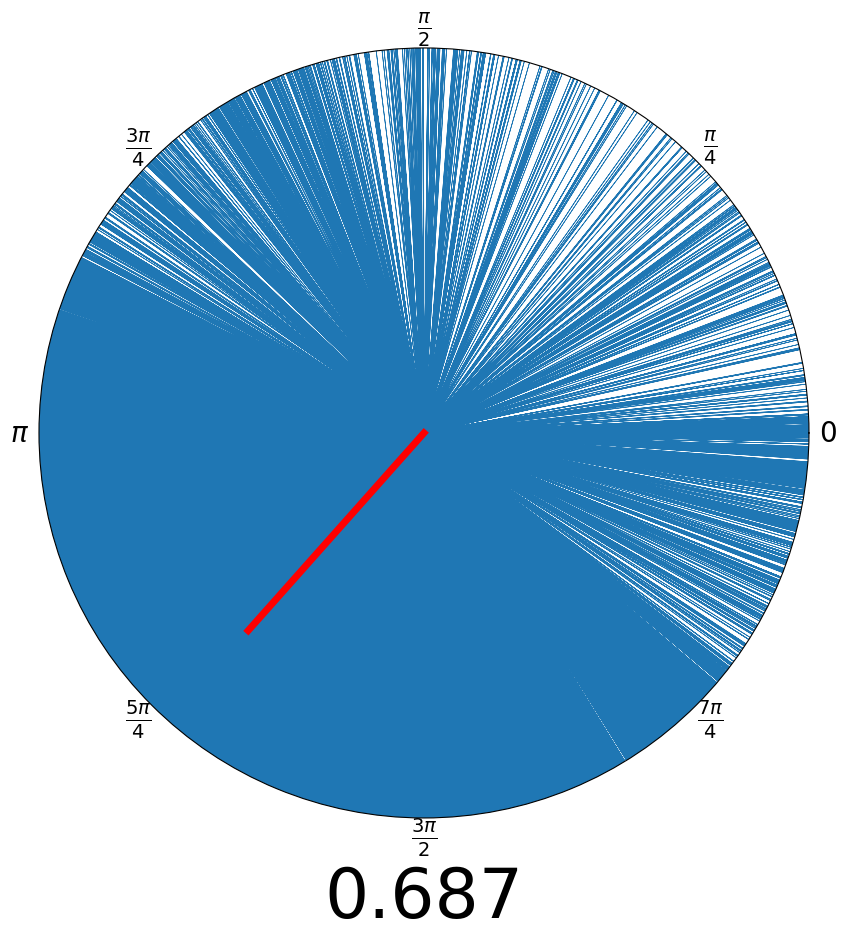

2023-04-16 18:09:05.878 | SUCCESS  | __main__:<module>:94 - DONE: train Data - Event 1
2023-04-16 18:09:05.882 | INFO     | __main__:<module>:23 - MPC - Train Data - Event 2


The synchronization between CS and IC is 0.6081
The mean angle between CS and IC is -2.28 rad


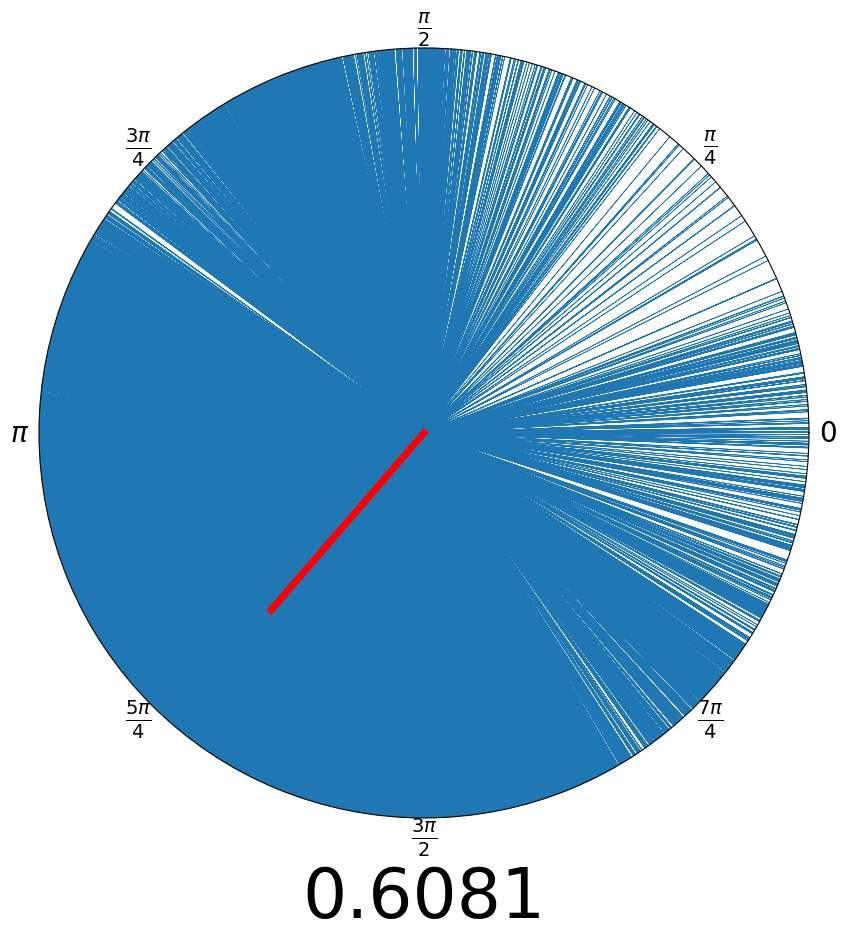

2023-04-16 18:09:07.574 | SUCCESS  | __main__:<module>:94 - DONE: train Data - Event 2
2023-04-16 18:09:07.577 | INFO     | __main__:<module>:23 - MPC - Train Data - Event 3


The synchronization between CS and IC is 0.5642
The mean angle between CS and IC is -2.75 rad


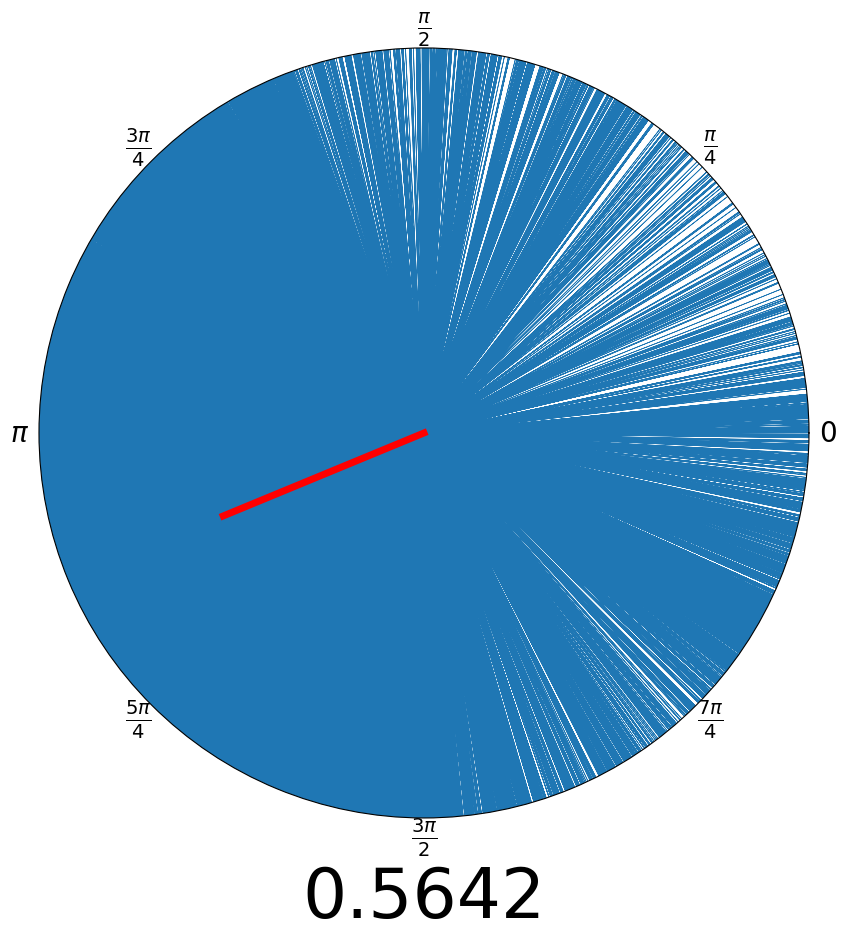

2023-04-16 18:09:09.125 | SUCCESS  | __main__:<module>:94 - DONE: train Data - Event 3
2023-04-16 18:09:09.128 | INFO     | __main__:<module>:23 - MPC - Train Data - Event 4


The synchronization between CS and IC is 0.3383
The mean angle between CS and IC is -1.95 rad


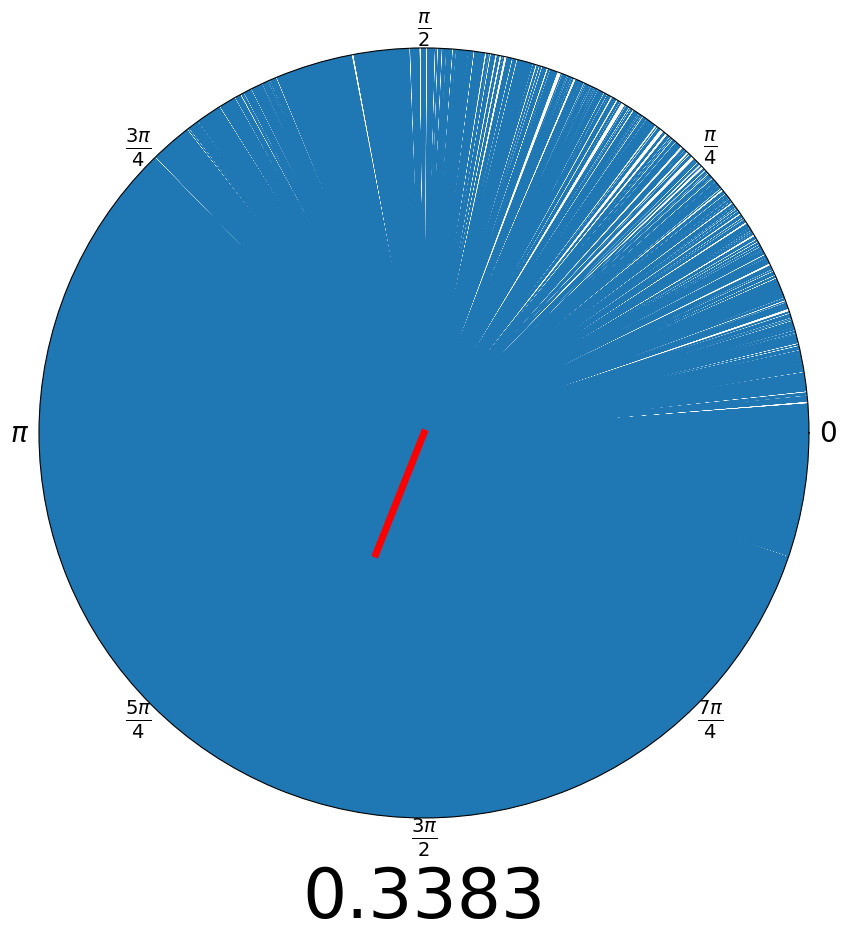

2023-04-16 18:09:10.762 | SUCCESS  | __main__:<module>:94 - DONE: train Data - Event 4
2023-04-16 18:09:10.765 | INFO     | __main__:<module>:23 - MPC - Train Data - Event 5


The synchronization between CS and IC is 0.4253
The mean angle between CS and IC is -2.66 rad


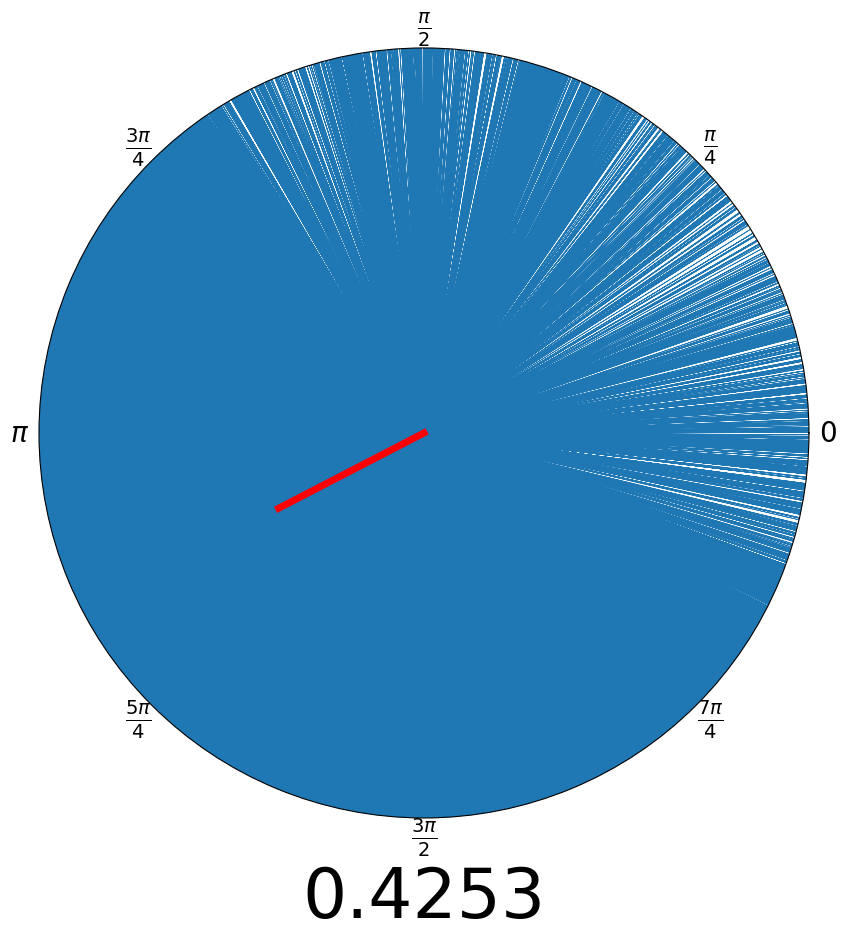

2023-04-16 18:09:12.307 | SUCCESS  | __main__:<module>:94 - DONE: train Data - Event 5


In [55]:
sliding_window_size = 3.0
extension_to_save_files = "jpg"
legend_size = 50

run_MPC_over_time: bool = False
run_MPC_sliding_window: bool = False
procces_raw_data: bool = False

name_data = "train"
data = data_train
del data_train

for event_number in range(1, 6):
    column = "filtered_Inferior_colliculus"

    event_data = select_event_window(
        df=data, 
        event_name=f"event_{event_number}", 
        samples_before=0, 
        samples_after=0
    )

    logger.info(f'MPC - {name_data.capitalize()} Data - Event {event_number}')

    phase_sync, phase_angle = get_MPC(
        signal1 = event_data.CS_modulating, 
        signal2 = event_data.loc[:, column],
        signal1_name = "CS",
        signal2_name = "IC",
        sliding_window = False,
        sliding_window_size = sliding_window_size,
        TimeSampling = TimeSampling,
        save=False,
        name_to_save=f'MPC_{name_data}_event_{event_number}' + \
        f'.{extension_to_save_files}',
        legend_size=legend_size
    )

    if run_MPC_sliding_window:
        logger.info(f'Sliding MPC polar - {name_data.capitalize()} Data - Event {event_number}')

        phase_sync_array, phase_angle_array = get_MPC(
            signal1 = event_data.CS_modulating, 
            signal2 = event_data.loc[:, column],
            signal1_name = "CS",
            signal2_name = "IC",
            sliding_window = True,
            sliding_window_size = sliding_window_size,
            TimeSampling = TimeSampling,
            save=True,
            name_to_save=f'sliding_MPC_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            legend_size=legend_size
        )

    if run_MPC_over_time:
        logger.info(f'sliding MPC over time - {name_data.capitalize()} Data - Event {event_number}')

        plt.figure(figsize=(14,10))

        t = 0
        for MPC in phase_sync_array:
            plt.plot([t, t, t + sliding_window_size, t + sliding_window_size], [0, MPC, MPC, 0])
            t += sliding_window_size

        plt.xlabel("time [s]")
        plt.ylabel('Mean Phase Clustering')
        plt.ylim([0, 1])
        plt.savefig(
            f'sliding_MPC_over_time_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

        frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)

        plt.figure(figsize=(14,10))

        plt.plot(frequency, intensity)

        plt.xlabel("frequency [Hz]")
        plt.ylabel('Intensity FFT')
        plt.xlim([50, 60])
        plt.savefig(
            f'FFT_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

    logger.success(f'DONE: {name_data} Data - Event {event_number}')

2023-04-16 18:09:12.318 | INFO     | __main__:<module>:23 - MPC - Test Data - Event 1


The synchronization between CS and IC is 0.5209
The mean angle between CS and IC is 3.12 rad


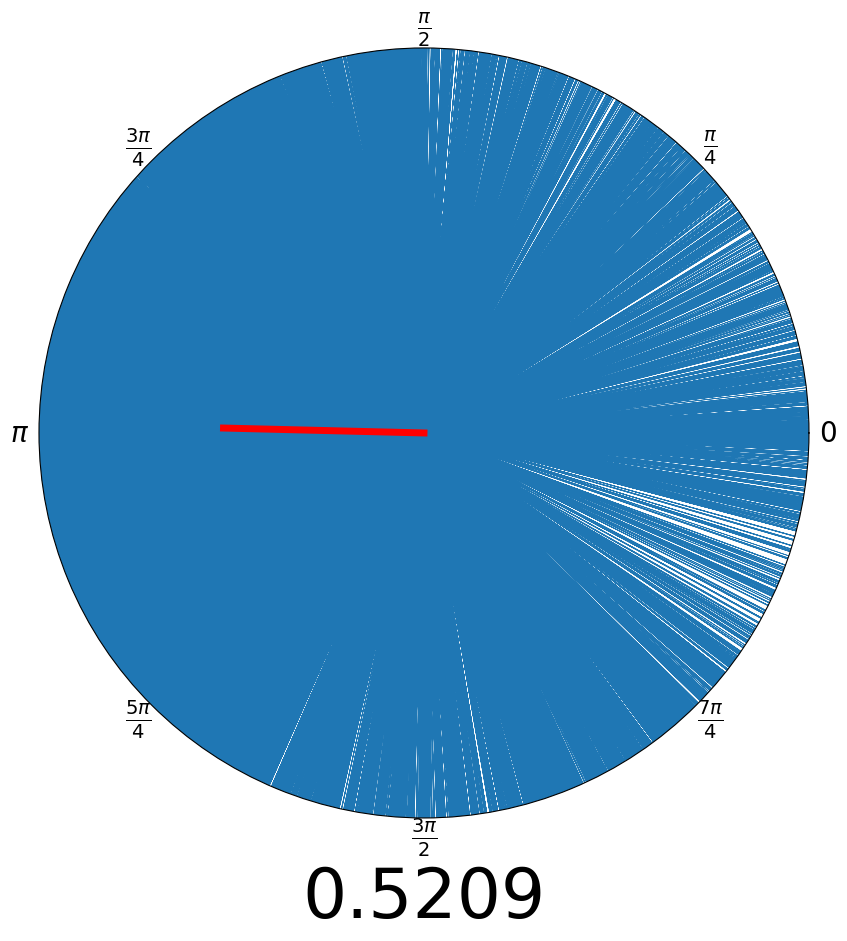

2023-04-16 18:09:16.386 | SUCCESS  | __main__:<module>:94 - DONE: test Data - Event 1
2023-04-16 18:09:16.389 | INFO     | __main__:<module>:23 - MPC - Test Data - Event 2


The synchronization between CS and IC is 0.4783
The mean angle between CS and IC is -2.95 rad


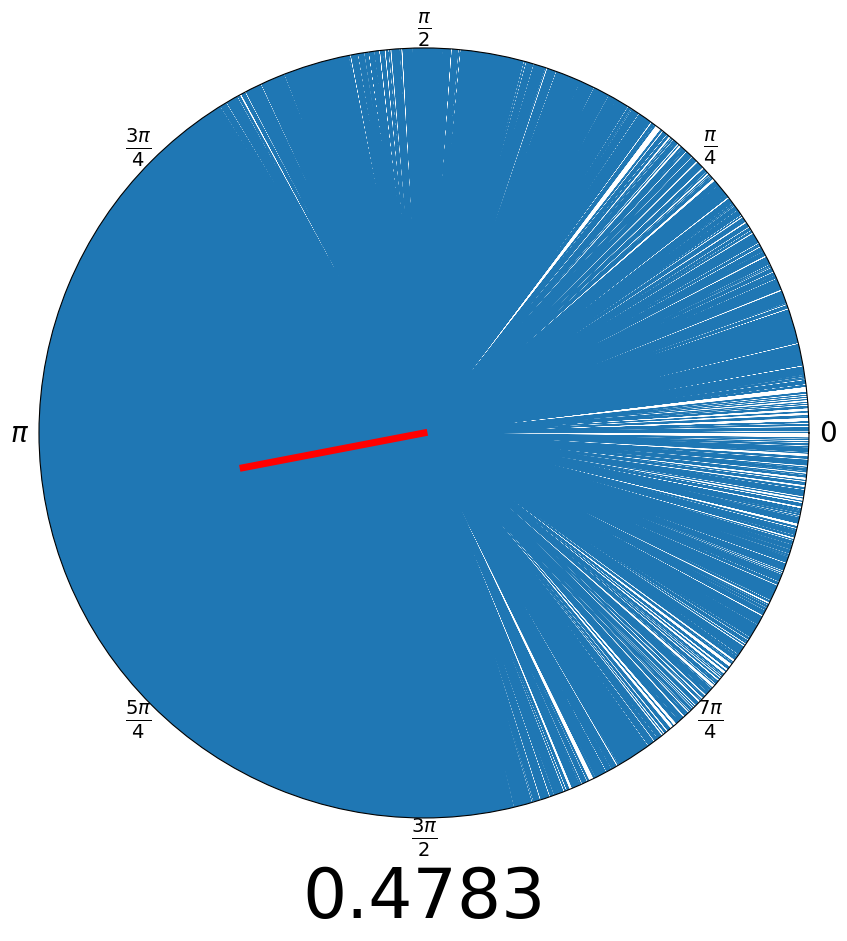

2023-04-16 18:09:20.700 | SUCCESS  | __main__:<module>:94 - DONE: test Data - Event 2
2023-04-16 18:09:20.704 | INFO     | __main__:<module>:23 - MPC - Test Data - Event 3


The synchronization between CS and IC is 0.4602
The mean angle between CS and IC is -3.09 rad


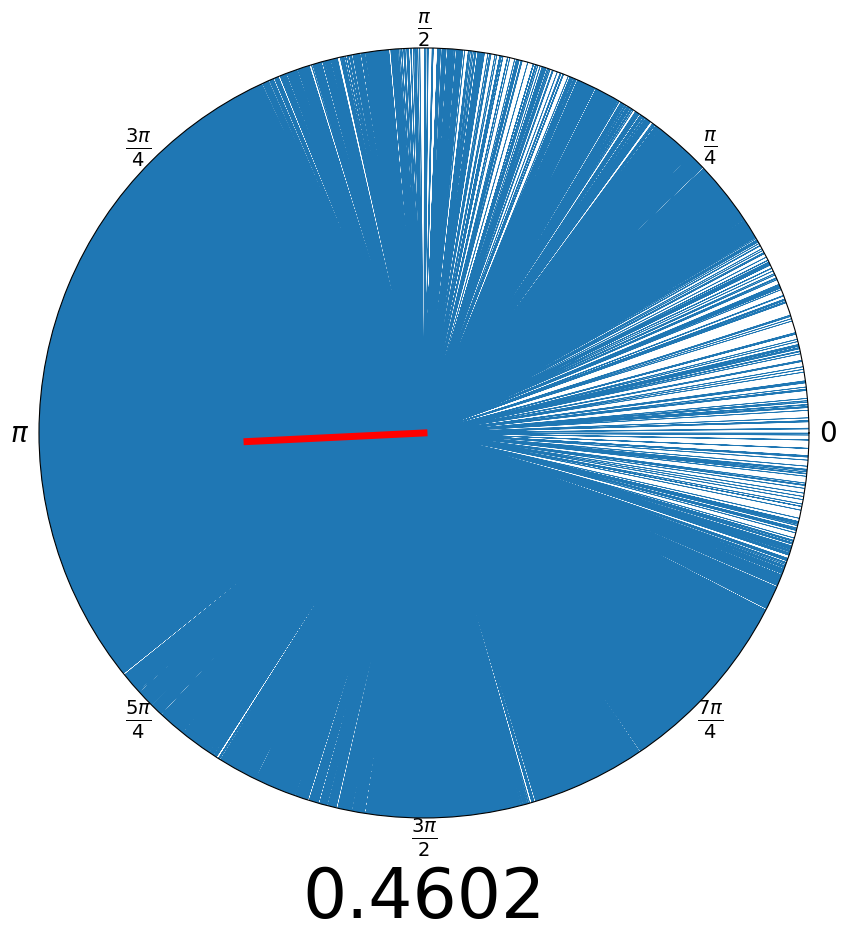

2023-04-16 18:09:24.913 | SUCCESS  | __main__:<module>:94 - DONE: test Data - Event 3
2023-04-16 18:09:24.916 | INFO     | __main__:<module>:23 - MPC - Test Data - Event 4


The synchronization between CS and IC is 0.5244
The mean angle between CS and IC is 3.08 rad


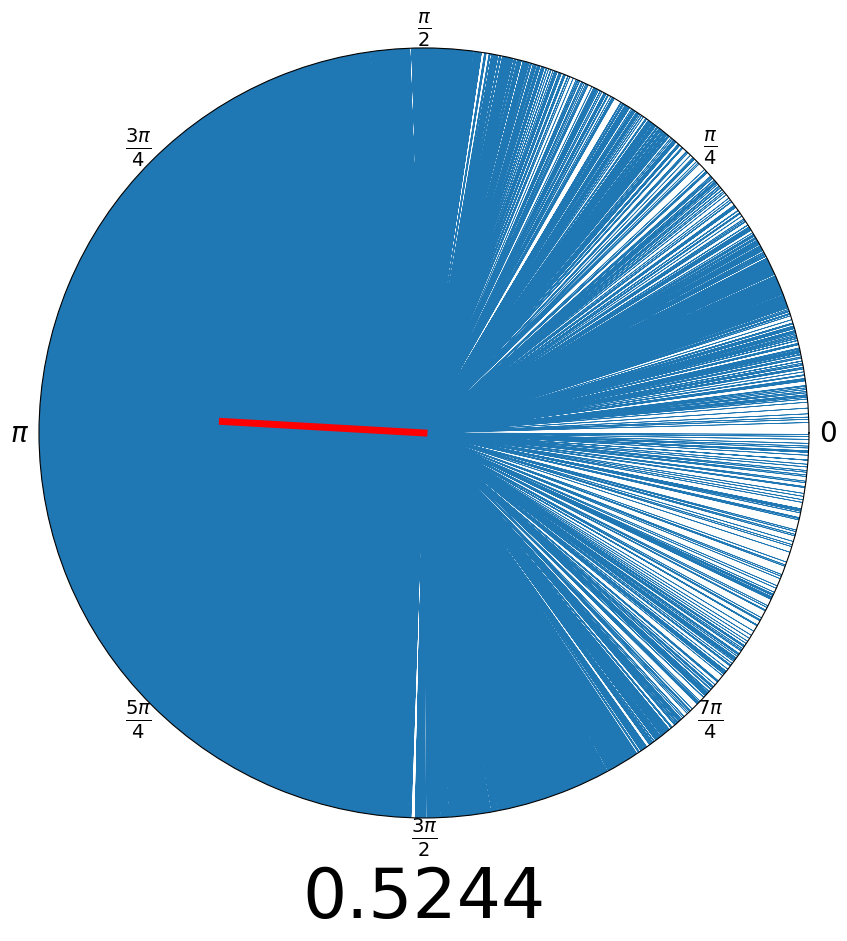

2023-04-16 18:09:29.318 | SUCCESS  | __main__:<module>:94 - DONE: test Data - Event 4
2023-04-16 18:09:29.321 | INFO     | __main__:<module>:23 - MPC - Test Data - Event 5


The synchronization between CS and IC is 0.5544
The mean angle between CS and IC is -3.09 rad


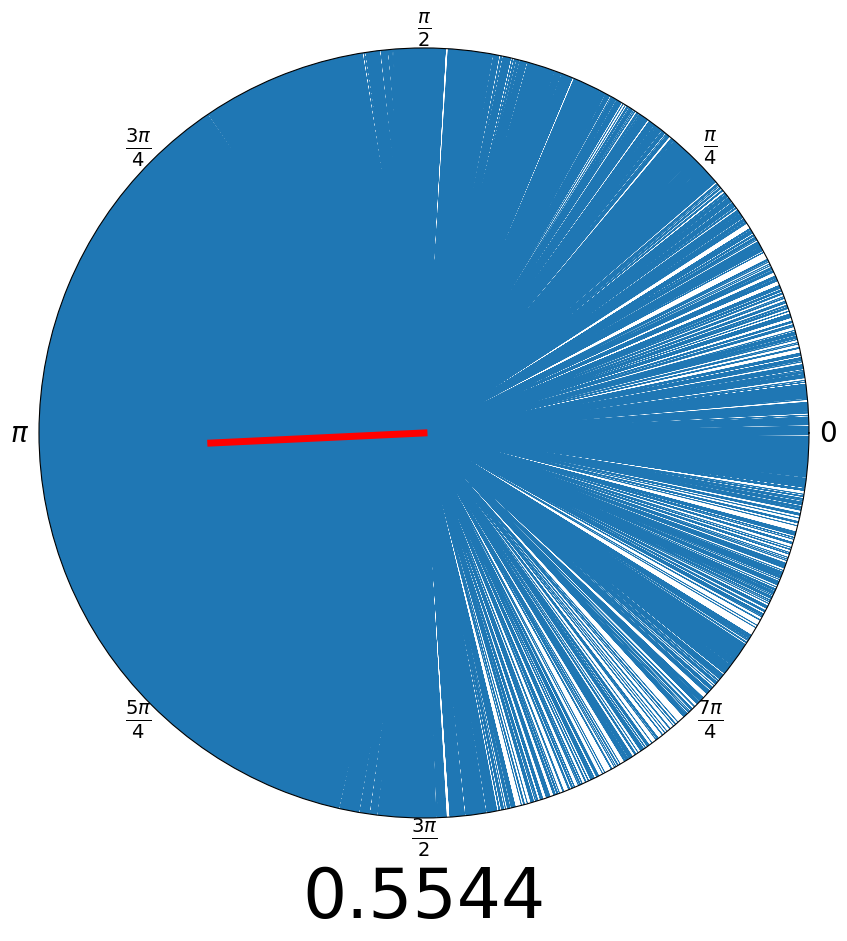

2023-04-16 18:09:33.562 | SUCCESS  | __main__:<module>:94 - DONE: test Data - Event 5


In [56]:
sliding_window_size = 3.0
extension_to_save_files = "jpg"
legend_size = 50

run_MPC_over_time: bool = False
run_MPC_sliding_window: bool = False
procces_raw_data: bool = False

name_data = "test"
data = data_test
del data_test

for event_number in range(1, 6):
    column = "filtered_Inferior_colliculus"

    event_data = select_event_window(
        df=data, 
        event_name=f"event_{event_number}", 
        samples_before=0, 
        samples_after=0
    )

    logger.info(f'MPC - {name_data.capitalize()} Data - Event {event_number}')

    phase_sync, phase_angle = get_MPC(
        signal1 = event_data.CS_modulating, 
        signal2 = event_data.loc[:, column],
        signal1_name = "CS",
        signal2_name = "IC",
        sliding_window = False,
        sliding_window_size = sliding_window_size,
        TimeSampling = TimeSampling,
        save=True,
        name_to_save=f'MPC_{name_data}_event_{event_number}' + \
        f'.{extension_to_save_files}',
        legend_size=legend_size
    )

    if run_MPC_sliding_window:
        logger.info(f'Sliding MPC polar - {name_data.capitalize()} Data - Event {event_number}')

        phase_sync_array, phase_angle_array = get_MPC(
            signal1 = event_data.CS_modulating, 
            signal2 = event_data.loc[:, column],
            signal1_name = "CS",
            signal2_name = "IC",
            sliding_window = True,
            sliding_window_size = sliding_window_size,
            TimeSampling = TimeSampling,
            save=True,
            name_to_save=f'sliding_MPC_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            legend_size=legend_size
        )

    if run_MPC_over_time:
        logger.info(f'sliding MPC over time - {name_data.capitalize()} Data - Event {event_number}')

        plt.figure(figsize=(14,10))

        t = 0
        for MPC in phase_sync_array:
            plt.plot([t, t, t + sliding_window_size, t + sliding_window_size], [0, MPC, MPC, 0])
            t += sliding_window_size

        plt.xlabel("time [s]")
        plt.ylabel('Mean Phase Clustering')
        plt.ylim([0, 1])
        plt.savefig(
            f'sliding_MPC_over_time_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

        frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)

        plt.figure(figsize=(14,10))

        plt.plot(frequency, intensity)

        plt.xlabel("frequency [Hz]")
        plt.ylabel('Intensity FFT')
        plt.xlim([50, 60])
        plt.savefig(
            f'FFT_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

    logger.success(f'DONE: {name_data} Data - Event {event_number}')

In [57]:
logger.success("Done")

2023-04-16 18:09:33.565 | SUCCESS  | __main__:<module>:1 - Done
